In [464]:
import os
import xai
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import log_loss, r2_score
import pickle
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor

mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 11.5
plt.rcParams['figure.figsize'] = (14,4)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FactorAnalysis, PCA

In [3]:
starbucksDT = pd.read_excel('/Users/dhkim/PycharmProjects/starbucksDT/rawdata/총합/fulldata_2020730.xlsx', sheet_name=1)

Text(0.8, 0.6, 'mean : 41.39\nmedian : 30.25')

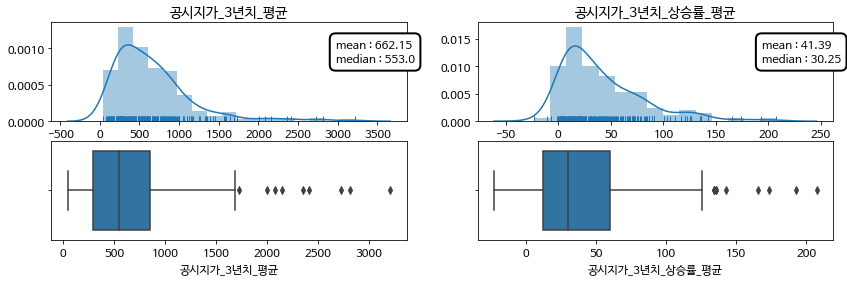

In [4]:

fig, axs = plt.subplots(nrows=2,ncols=2)
bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
sns.distplot(starbucksDT['공시지가_3년치_평균'],rug=True, ax=axs[0,0])
sns.boxplot(starbucksDT['공시지가_3년치_평균'], ax=axs[1,0])
axs[0,0].set_title('공시지가_3년치_평균')
axs[0,0].annotate(f"mean : {starbucksDT['공시지가_3년치_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)
sns.distplot(starbucksDT['공시지가_3년치_상승률_평균'],rug=True, ax=axs[0,1])
sns.boxplot(starbucksDT['공시지가_3년치_상승률_평균'], ax=axs[1,1])
axs[0,1].set_title('공시지가_3년치_상승률_평균')
axs[0,1].annotate(f"mean : {starbucksDT['공시지가_3년치_상승률_평균'].mean():.2f}\nmedian : {starbucksDT['공시지가_3년치_상승률_평균'].median()}",
            xy=(0.8, 0.6),
            xycoords='axes fraction',
            xytext=(0.8, 0.6),
            bbox=bbox_props)

In [5]:
starbucksDT['공시지가_3년치_상승률_평균'] = starbucksDT['공시지가_3년치_상승률_평균'].fillna(starbucksDT['공시지가_3년치_상승률_평균'].median())
starbucksDT['공시지가_3년치_평균'] = starbucksDT['공시지가_3년치_평균'].fillna(starbucksDT['공시지가_3년치_평균'].median())

In [424]:
def visualize_feature_importance(corr_df, label_cols, except_cols):
    df = corr_df.copy()
    num_cols = 2
    num_row, q = divmod(len(label_cols), num_cols)
    num_row += q
    fig, axs = plt.subplots(nrows=num_row, ncols=num_cols)
    bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
    df_dict =  {'features':[],
                'values':[],
                'kinds':[]}
    top_values_dict = {}
    for idx, feature in enumerate(label_cols):
        temp_series = corr_df.loc[feature, corr_df.columns.map(lambda x:x not in except_cols)]
        temp_series = temp_series[temp_series.abs().argsort()[::-1]]
        top_values = temp_series[0:20][temp_series[0:20].map(lambda x:np.abs(x)>0.15)]
        axs[idx//2, idx%2].set_title(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')
        try:
            sns.barplot(x=top_values.values, y=top_values.index, ax=axs[idx//2, idx%2])
            num_, mean_, max_ = len(top_values), np.round(top_values.abs().mean(), 2), np.round(top_values.abs().max(), 2)
            df_dict['features'].append(np.repeat([feature],3))
            df_dict['values'].append([num_, mean_, max_])
            df_dict['kinds'].append(['num','mean','max'])
            
            axs[idx//2, idx%2].annotate(f'0.15 이상 feature 개수 : {num_}\n0.15 이상 |feature| 평균 : {mean_}\n0.15 이상 feature 최댓값 : {max_}',
                                        xy=(0.8, 0.6),
                                        xycoords='axes fraction',
                                        xytext=(0.4, 0.6),
                                        bbox=bbox_props)
            top_values_dict[feature] = top_values
        except Exception as e:
            if len(top_values)==0:
                print(f'this {feature} has not important features')
            else:
                print(e)
    df_dict['features'] = np.concatenate(df_dict['features'])
    df_dict['values'] = np.concatenate(df_dict['values'])
    df_dict['kinds'] = np.concatenate(df_dict['kinds'])

    df_compare = pd.DataFrame(df_dict)
    
    fig.set_size_inches(16, 10)
    fig.tight_layout()
    visualize_feature_compare(df_compare)
    return df_compare, top_values_dict

def visualize_feature_compare(df):
    plt.figure(figsize=(16,7))
    df_compare = df.copy()
    
    num_mask = df_compare.kinds == 'num'
    scale = df_compare.loc[num_mask, 'values'].median() / df_compare.loc[~num_mask, 'values'].abs().median()
    df_compare.loc[~num_mask, 'values'] = df_compare.loc[~num_mask, 'values'] * scale
    ax1 = sns.barplot(x='features',y='values',data=df_compare,hue='kinds')
    ax1.set_ylabel('feature 개수')
    
    # Create a second y-axis with the scaled ticks
    ax2 = ax1.twinx()
    
    # Ensure ticks occur at the same positions, then modify labels
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels(np.round(ax1.get_yticks()/scale, 2))
    ax2.set_ylabel('|feature| 평균값 및 최댓값')
    
    def add_bar_text(ax, num_length, scale):
        for idx, patch in enumerate(ax.patches):
            value = str(int(patch.get_height()))
            if idx > num_length-1:
                value = f'{patch.get_height()/scale:.2f}'
            ax.annotate(value, 
                        (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')
    add_bar_text(ax1, np.sum(num_mask), scale)
#     fig.suptitle(f'{feature} 상관계수 시각화', y=1.05, x=0.5, size=14, color='black')

this 6개월_점수 has not important features


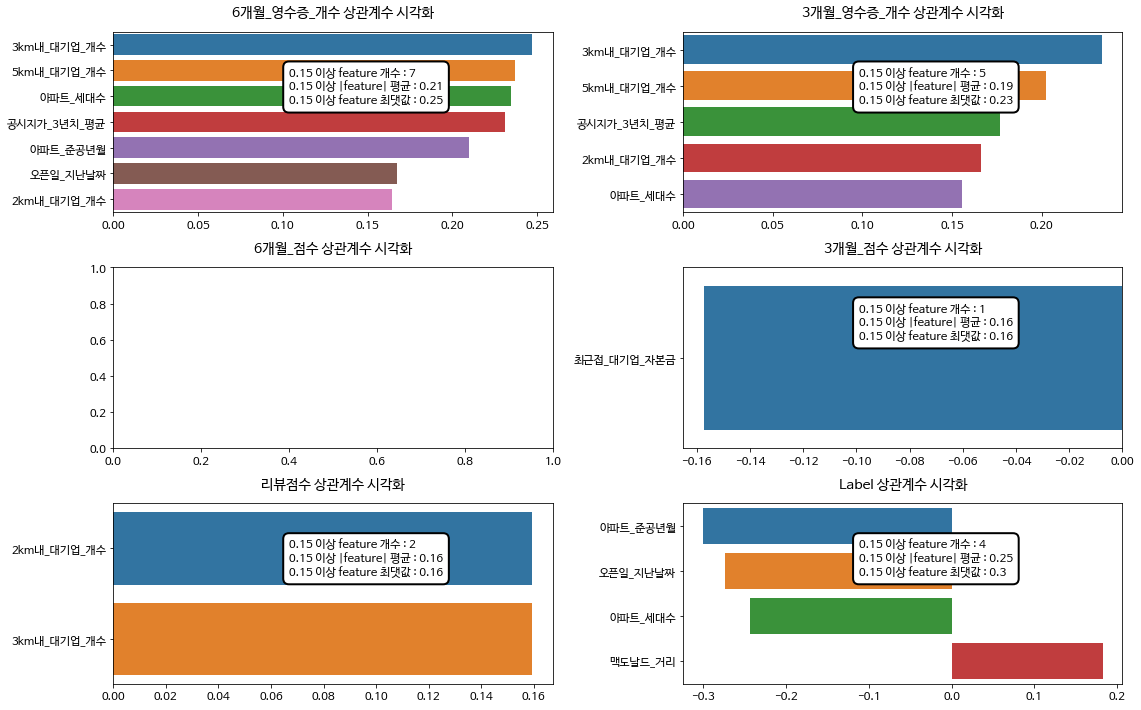

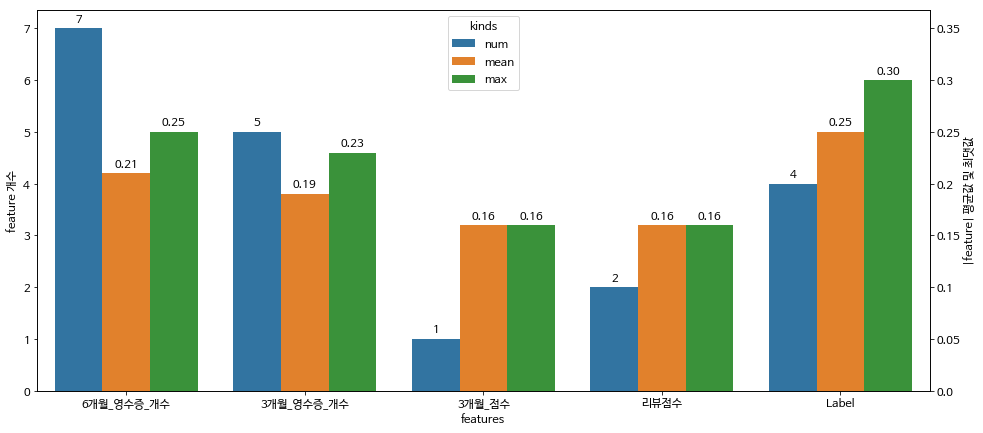

In [426]:
corr_df = starbucksDT.corr()
except_cols = starbucksDT.loc[:, starbucksDT.columns.map(lambda x:('지점명' == x) or ('오픈일' == x) or ('분류' == x) or ('경도' == x) 
                                                         or ('위도' == x) or ('1년' in x) or ('관광지명' == x) or ('최근접_대기업명' == x) 
                                                         or ('개월' in x) or ('Label' in x) or ('리뷰점수' == x) or ('영수증' in x))].columns
label_cols = ['6개월_영수증_개수', '3개월_영수증_개수', '6개월_점수', '3개월_점수', '리뷰점수', 'Label']

df_compare, top_values = visualize_feature_importance(corr_df, label_cols, except_cols)

In [64]:
target_lables = ['6개월_영수증_개수', 'Label']
feature_names = list(starbucksDT.loc[:, starbucksDT.columns.map(lambda x:x not in except_cols)].columns)
print(feature_names)

['M', 'Tu', 'W', 'Th', 'Fr', 'Sa', 'S', '00~03', '03~06', '06~09', '09~12', '12~15', '15~18', '18~21', '12~24', 'M_20', 'M_25', 'M_29', 'M_34', 'M_39', 'M_44', 'M_49', 'M_54', 'M_59', 'M_60', 'W_20', 'W_25', 'W_29', 'W_34', 'W_39', 'W_44', 'W_49', 'W_54', 'W_59', 'W_60', '관광지_거리', '관광지_리뷰수', '교통량_점수', '교통량_점수_아침', '교통량_점수_저녁', '교통량_점수_점심', '교통량_점수_주말', '교통량_점수_평일', '맥도날드_거리', '인근_스타벅스_거리', '아파트_거리', '아파트_매매가_상한', '아파트_세대수', '아파트_준공년월', '인근_교차로_거리(m)', '주유소_거리(m)', '최근접_대기업_거리', '최근접_대기업_자본금', '1km내_대기업_개수', '2km내_대기업_개수', '3km내_대기업_개수', '5km내_대기업_개수', '동단위_아파트_세대수', '공시지가_3년치_평균', '공시지가_3년치_상승률_평균', '오픈일_지난날짜']


In [50]:
class StarbucksDT(object):
    def __init__(self, df, label_col):
        self.trip = df.loc[df[label_col]=='관광',:].reset_index(drop=True)
        self.company = df.loc[df[label_col]=='사업체',:].reset_index(drop=True)
        self.IC = df.loc[df[label_col]=='IC근처',:].reset_index(drop=True)
        self.apt = df.loc[df[label_col]=='아파트',:].reset_index(drop=True)
stDT = StarbucksDT(starbucksDT, '분류')

In [439]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def normalization_train_test(df_train, df_test, target_cols, method='standard', label_col_include=False):
    if method=='standard':
        sc = StandardScaler()
    elif method=='minmax':
        sc = MinMaxScaler()
    if label_col_include:
        target_cols = target_cols + [label_col_include]
    except_cols = df_train.loc[:, df_train.columns.map(lambda x:x not in target_cols)].columns
    
    df_train_sc = sc.fit_transform(df_train.loc[:, target_cols])
    df_test_sc = sc.transform(df_test.loc[:, target_cols])

    df_train_sc = pd.DataFrame(df_train_sc, columns=target_cols, index=list(df_train.index.values))
    df_test_sc = pd.DataFrame(df_test_sc, columns=target_cols, index=list(df_test.index.values))

    df_train_sc[except_cols] = df_train[except_cols]
    df_test_sc[except_cols] = df_test[except_cols]
    
    return df_train_sc, df_test_sc

class Kfold(object):
    def __init__(self, k=3):
        self.k = k
        self.train_scores = {}
        self.test_scores = {}
        self.train_errors = {}
        self.test_errors = {}
        self.data_idx_train = {}
        self.data_idx_test = {}
        self.best_model = {}
        self.best_train = {}
        self.best_test = {}
        
    @staticmethod
    def get_r2_score(y_true, y_pred):
        rss = ((y_true - y_pred) ** 2).sum()
        tss = ((y_true - y_true.mean())** 2).sum()
        rsquared = 1 - rss / tss
        return rsquared   
    
    @staticmethod
    def get_cross_val_score(model, df, train_features, label_feature, k, normalization, task):
        data_idx_train = []
        data_idx_test = []
        train_scores = np.zeros(k)
        train_errors = np.zeros(k)
        test_scores = np.zeros(k)
        test_errors = np.zeros(k)
        cv = KFold(k, shuffle=True, random_state=0)

        for i, (idx_train, idx_test) in enumerate(cv.split(df)):
            df_train = df.iloc[idx_train]
            df_test = df.iloc[idx_test]
            df_train, df_test = normalization_train_test(df_train, df_test, target_cols=train_features,
                                                         method=normalization, label_col_include=label_feature)
            if model is None:
                model = sm.OLS.from_formula(f"{label_feature} ~ " + " + ".join(train_features), data=df_train)
                result = model.fit()
                pred = result.predict(df_test)
            else:
                model = model.fit(df_train[train_features], df_train[label_feature])
            data_idx_train.append(idx_train)
            data_idx_test.append(idx_test)
            if task=='regression':
                train_score = Kfold.get_r2_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = Kfold.get_r2_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
            elif task=='classification':
                train_score = accuracy_score(df_train[label_feature], model.predict(df_train[train_features]))
                test_score = accuracy_score(df_test[label_feature], model.predict(df_test[train_features]))
                train_error = mean_squared_error(df_train[label_feature], model.predict(df_train[train_features]))
                test_error = mean_squared_error(df_test[label_feature], model.predict(df_test[train_features]))
                
            train_scores[i] = train_score
            test_scores[i] = test_score
            train_errors[i] = train_error
            test_errors[i] = test_error
        
#         print("학습 평균 score = {:.8f}, 검증 평균 score = {:.8f}".format(np.mean(train_scores), np.mean(test_scores)))
        return train_scores, test_scores, train_errors, test_errors, data_idx_train, data_idx_test
    
    def cross_val(self, model_name, model, df, train_features, label_feature, normalization='minmax', task='classification'):
        values = Kfold.get_cross_val_score(model, df, train_features, label_feature, self.k, normalization, task)
        self.train_scores[model_name] = values[0]
        self.test_scores[model_name] = values[1]
        self.train_errors[model_name] = values[2]
        self.test_errors[model_name] = values[3]
        self.data_idx_train[model_name] = values[4]
        self.data_idx_test[model_name] = values[5]
#         print(f'{"*"*15} {label_feature} complete {"*"*15}\n')
        return self
    
    def best_visualize(self, model_name, model, df, train_features, label_feature, normalization):
        data_idx_train = self.data_idx_train[model_name]
        data_idx_test = self.data_idx_test[model_name]
        
        total_scores = self.train_scores[model_name] + self.test_scores[model_name]
        arg_best = np.argmax(total_scores)
        best_train = df.iloc[data_idx_train[arg_best]]
        best_test = df.iloc[data_idx_test[arg_best]]
        self.best_train[model_name] = best_train
        self.best_test[model_name] = best_test
        best_train, best_test = normalization_train_test(best_train, best_test, target_cols=train_features,
                                                         method=normalization, label_col_include=label_feature)
        x_train, y_train = best_train[train_features], best_train[label_feature]
        x_test, y_test = best_test[train_features], best_test[label_feature]
        
        best_model = model
        best_model = best_model.fit(x_train, y_train)
        self.best_model[model_name] = best_model
        fig, axs = plt.subplots(2, 2)
        Kfold.visualize_result(y_test, best_model.predict(x_test), axs[0, :], 'test data',
                               model_title=model_name, label_name=label_feature, etc=self.k,
                               score=self.test_scores[model_name][arg_best])
        Kfold.visualize_result(y_train, best_model.predict(x_train), axs[1, :], 'train data',
                               model_name, label_name=label_feature, etc=self.k,
                               score=self.train_scores[model_name][arg_best])
        fig.suptitle(f'{model_name} results [target : {label_feature}]', y=1.05, x=0.5, size=24, color='black')
        fig.set_size_inches(16, 10)
        fig.tight_layout()
        
    @staticmethod
    def reset_param():
        mpl.rcParams['axes.unicode_minus'] = False
        plt.rcParams['font.family'] = 'NanumBarunGothic'
        plt.rcParams['font.size'] = 11.5
        plt.rcParams['figure.figsize'] = (5,3)
    
    @staticmethod
    def visualize_result(y_test, y_pred, axs, title='test data', model_title='linearmodel',label_name='Y', etc='3', score=0):
        sns.lineplot(x=np.arange(0,len(y_test),1),y=y_test, color = 'red', label = 'Real data', ax=axs[0])
        sns.lineplot(x=np.arange(0,len(y_pred),1),y=y_pred, color = 'blue', label = 'Predicted data', ax=axs[0])
        axs[0].set_title(f'{etc}fold {model_title} {label_name} Prediction {title}')
        Kfold.visualize_linear(y_test, y_pred, axs[1], label_name, title, score)
        reset_param()

    @staticmethod
    def visualize_linear(y_test, y_pred, ax, label_name, title, score):
        bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)
        ax.annotate(f'best {title} \n r2 score {np.round(score,3)}',
                    xy=(0.8, 0.6),
                    xycoords='axes fraction',
                    xytext=(0.04, 0.75),
                    bbox=bbox_props,
                    size=14)
        sns.scatterplot(y_test, y_pred, color = 'blue', ax=ax)
        x_len = len(y_test)
        x = np.linspace(0,1,x_len)
        sns.lineplot(x, x, color = 'red', label = 'ideal', ax=ax)
        ax.set_xlabel(f"{label_name}" + " : $Y_i$")
        ax.set_ylabel(f"Predicted {label_name}: " + "$\hat{Y}_i$")
        ax.set_title(f"Real {label_name} vs Predicted {label_name}" + " : $Y_i$ vs $\hat{Y}_i$")
#         plt.show()        
        
class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)
    
def add_bar_text(ax):
    for idx, patch in enumerate(ax.patches):
        value = f'{patch.get_height()}'
        ax.annotate(value, 
                    (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

In [468]:
def supervised_modeling(df, model, model_name, feature_names, target_labels, normalization='minmax', task='regression'):
    kfolds = {}
    kfold_scores = {}
    kfold_scores['label'] = []
    kfold_scores['values'] = []
    kfold_scores['kind'] = []
    kfold_scores['model_name'] = []
    kfold_scores['k'] = []
    k_values = [3, 5, 10]
        
    for target_label in target_lables:
        if isinstance(feature_names, dict):
            feature_names_for_label = feature_names[target_label]
        else:
            feature_names_for_label = feature_names
        kfolds[target_label] = []
        for idx, k in enumerate(k_values):
            kfold = Kfold(k)
            kfold.cross_val(model_name, model, df, feature_names_for_label, target_label, normalization=normalization, task=task)
            kfold_scores['label'].append(np.repeat([target_label], k*2))
            kfold_scores['values'].append(np.concatenate([kfold.train_scores[model_name], kfold.test_scores[model_name]]))
            kfold_scores['kind'].append(np.concatenate([np.repeat(['train'], k), np.repeat(['test'], k)]))
            kfold_scores['model_name'].append(np.repeat([model_name], k*2))
            kfold_scores['k'].append(np.repeat([k], k*2))
            kfolds[target_label].append(kfold)
        k_mean = np.asarray(list(map(lambda x:np.mean(x),kfold_scores['values'])))
        arg_max = np.argmax(np.mean(k_mean))
        print(f'{model_name}`s {kfolds[target_label][arg_max].k} is best for {target_label}\n')
        kfolds[target_label][arg_max].best_visualize(model_name, model, df, feature_names_for_label, target_label, normalization)

    for k,v in kfold_scores.items():
        kfold_scores[k] = np.concatenate(v)


    kfold_score_df = pd.DataFrame(kfold_scores)
    fig, axs = plt.subplots(2, 3)
    kfold_score_df1 = kfold_score_df.loc[kfold_score_df['label']==target_labels[0], :]
    kfold_score_df2 = kfold_score_df.loc[kfold_score_df['label']!=target_labels[0], :]
    bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="k", lw=2)

    for i, k in enumerate(k_values):
        sns.barplot(x=kfold_score_df1[kfold_score_df1.k==k].index,y='values',hue='kind',data=kfold_score_df1[kfold_score_df1.k==k], ax= axs[0, i])
        axs[0, i].set_title(f"target : {target_labels[0]}\nk={k}")
        axs[0, i].annotate(f'mean r2 score\n'
                           f'train : {np.round(kfold_score_df1[(kfold_score_df1.k==k)&(kfold_score_df1.kind=="train")]["values"].mean(),3)}\n'
                           f'test : {np.round(kfold_score_df1[(kfold_score_df1.k==k)&(kfold_score_df1.kind=="test")]["values"].mean(),3)}',
                           xy=(0.8, 0.6),
                           xycoords='axes fraction',
                           xytext=(0.94, 0.9),
                           bbox=bbox_props,
                           size=12)
        sns.barplot(x=kfold_score_df2[kfold_score_df2.k==k].index,y='values',hue='kind',data=kfold_score_df2[kfold_score_df2.k==k], ax= axs[1, i])
        axs[1, i].set_title(f"target : {target_labels[1]}\nk={k}")
        axs[1, i].annotate(f'mean r2 score\n'
                           f'train : {np.round(kfold_score_df2[(kfold_score_df2.k==k)&(kfold_score_df2.kind=="train")]["values"].mean(),3)}\n'
                           f'test : {np.round(kfold_score_df2[(kfold_score_df2.k==k)&(kfold_score_df2.kind=="test")]["values"].mean(),3)}',
                           xy=(0.8, 0.6),
                           xycoords='axes fraction',
                           xytext=(0.94, 0.9),
                           bbox=bbox_props,
                           size=12)

    fig.suptitle(f'k-fold cross validation R2 scores', y=1.05, x=0.5, size=14, color='black')
    fig.set_size_inches(16, 6)
    fig.tight_layout()
    return kfolds, kfold_score_df

## 전체 데이터

In [457]:
kfold_model = {'total':{},
               'trip':{},
               'IC':{},
               'apt':{},
               'company':{}}
kfold_results = {'total':{},
               'trip':{},
               'IC':{},
               'apt':{},
               'company':{}}

In [465]:
models = {
    'linear' : LinearRegression(),
    'lasso' : Lasso(),
    'ridge' : Ridge(),
    'sgd' : SGDRegressor(),
    'svr' : SVR(),
    'decisionTree' : DecisionTreeRegressor(),
    'extraTree' : ExtraTreeRegressor(),
    'randomForest' : RandomForestRegressor(),
    'adaBoost' : AdaBoostRegressor(),
    'gradientBoosting' : GradientBoostingRegressor(),
    'xgboost' : XGBRegressor()
}

In [ ]:
target_lables = ['6개월_영수증_개수', 'Label']
feature_names = list(starbucksDT.loc[:, starbucksDT.columns.map(lambda x:x not in except_cols)].columns)
print(feature_names)

3 is best for 6개월_영수증_개수

3 is best for Label



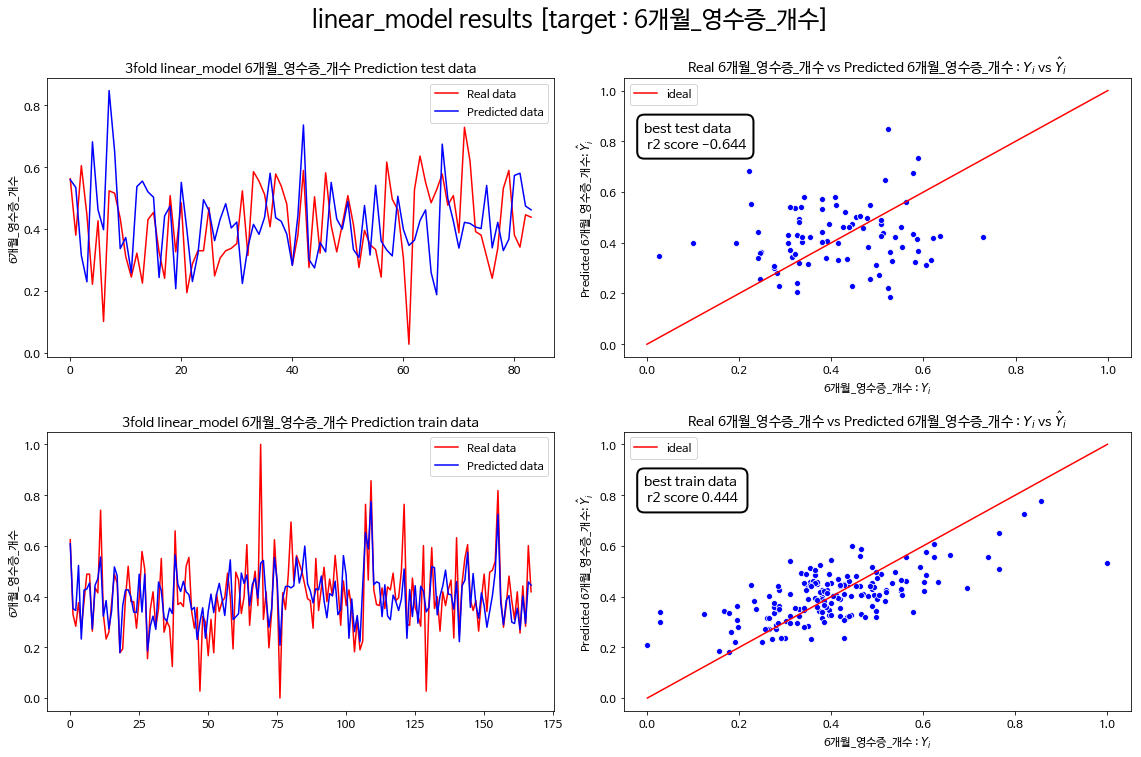

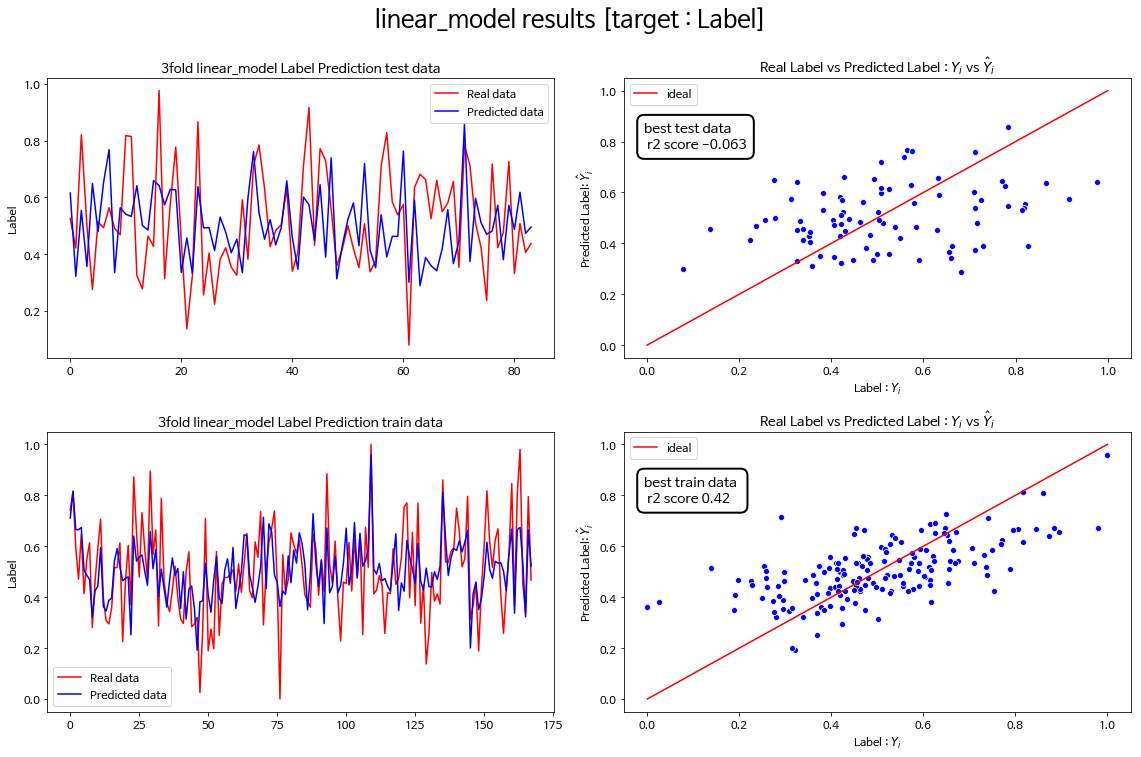

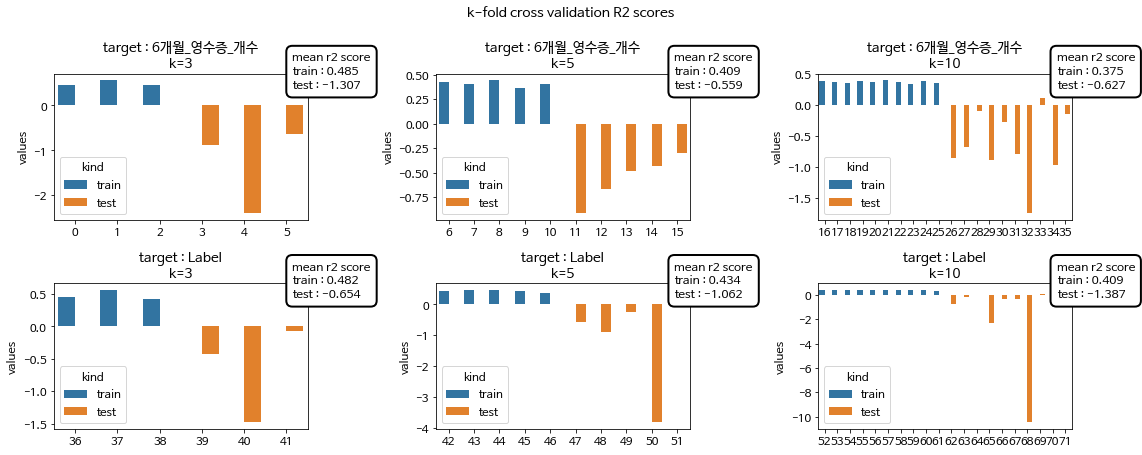

In [458]:
model_name = 'linear_model'
model = models['linear']
kfold_model['total'][model_name], kfold_results['total'][model_name] = supervised_modeling(starbucksDT, model, model_name, feature_names, target_lables)

## 전체 데이터에서 상관계수 값이 높은 feature만 사용하기

In [466]:
feature_names_dict = {}
feature_names_dict['6개월_영수증_개수'] = list(top_values['6개월_영수증_개수'].keys())
feature_names_dict['Label'] = list(top_values['Label'].keys())

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for 6개월_영수증_개수



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for Label



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for 6개월_영수증_개수



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for Label



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for 6개월_영수증_개수



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for Label



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for 6개월_영수증_개수



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


3 is best for Label



/Users/dhkim/.pyenv/versions/3.7.0/envs/xai/lib/python3.7/site-packages/matplotlib-3.0.2-py3.7-macosx-10.15-x86_64.egg/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


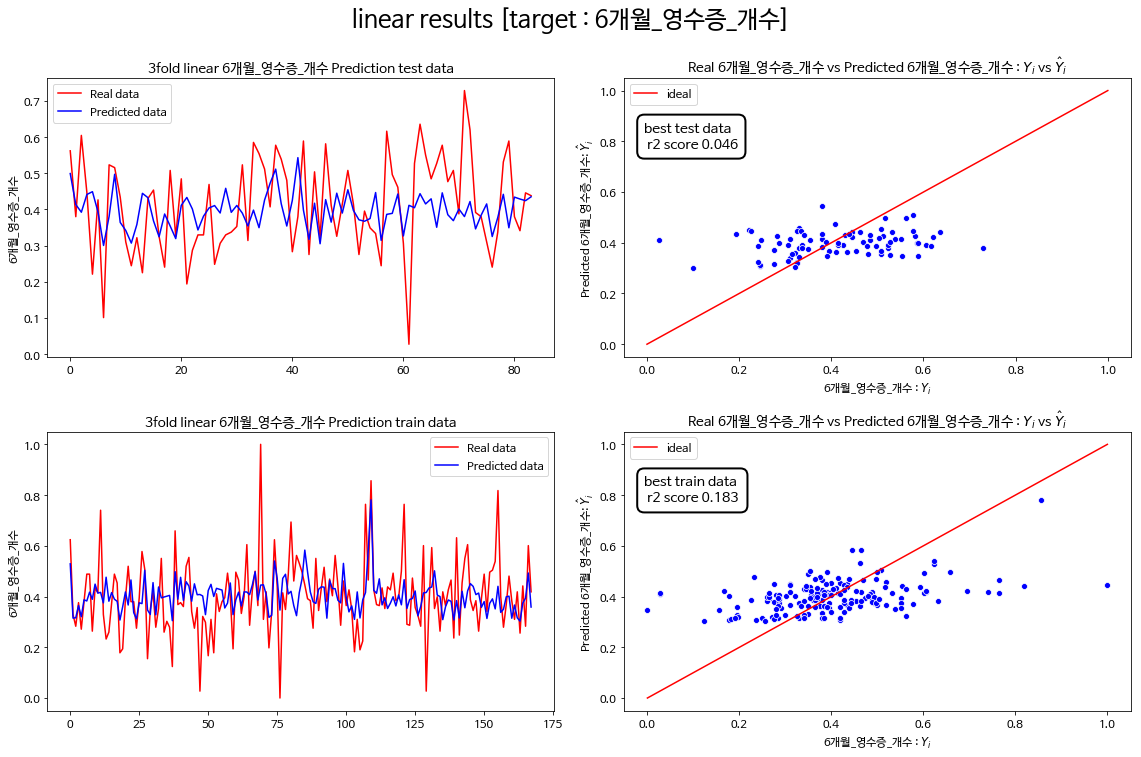

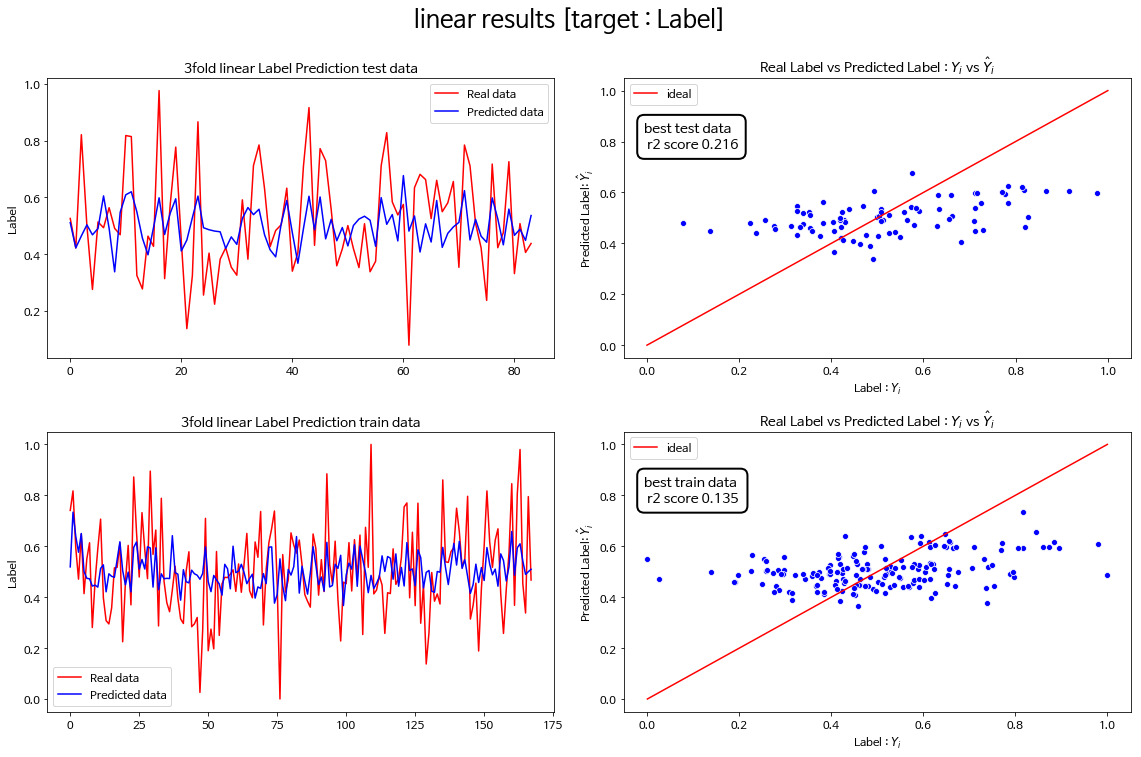

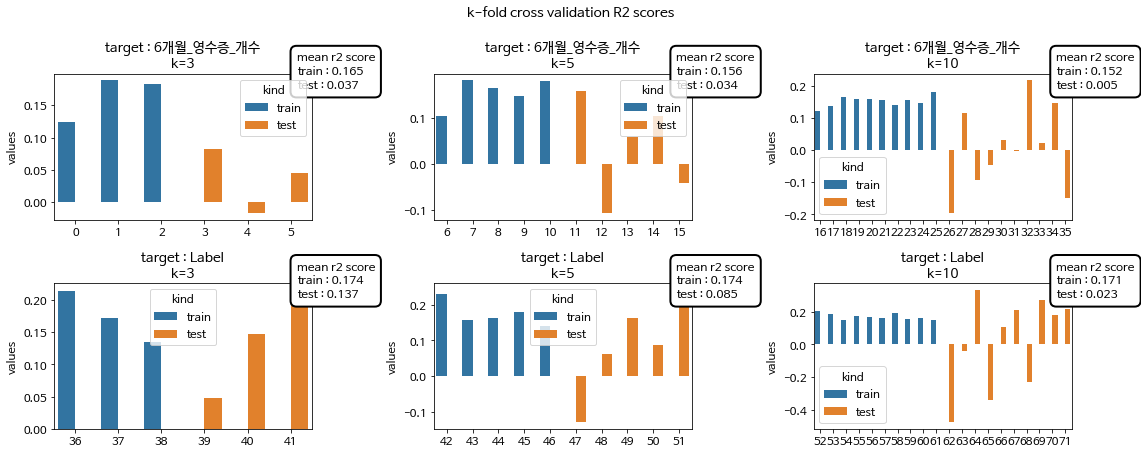

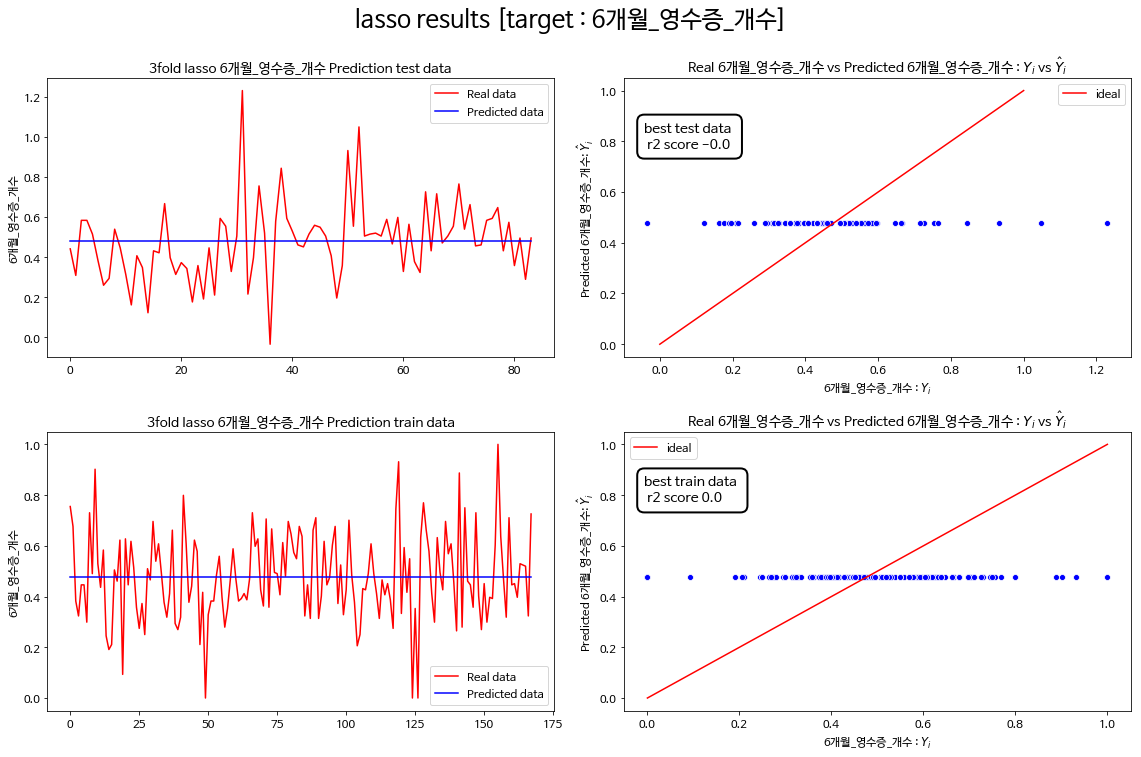

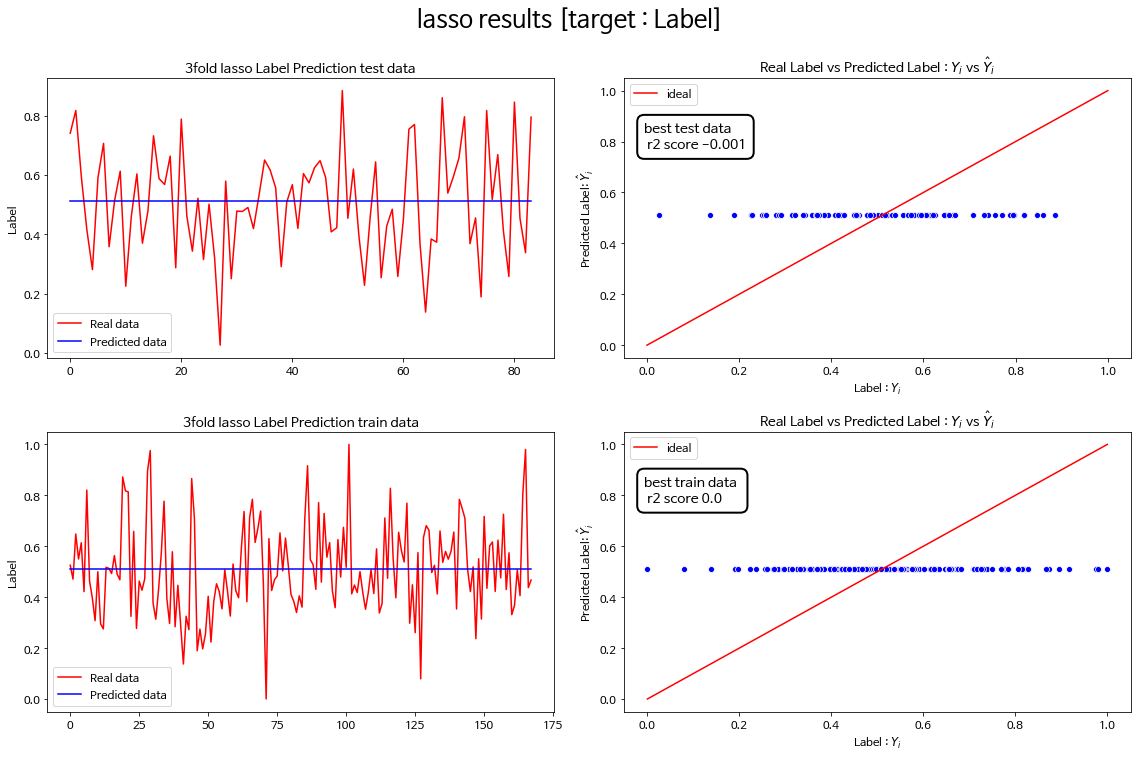

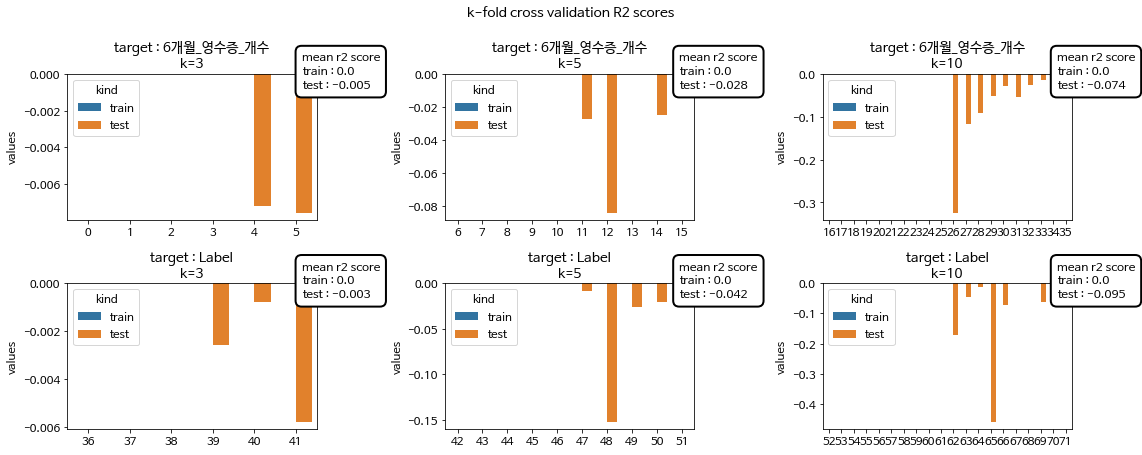

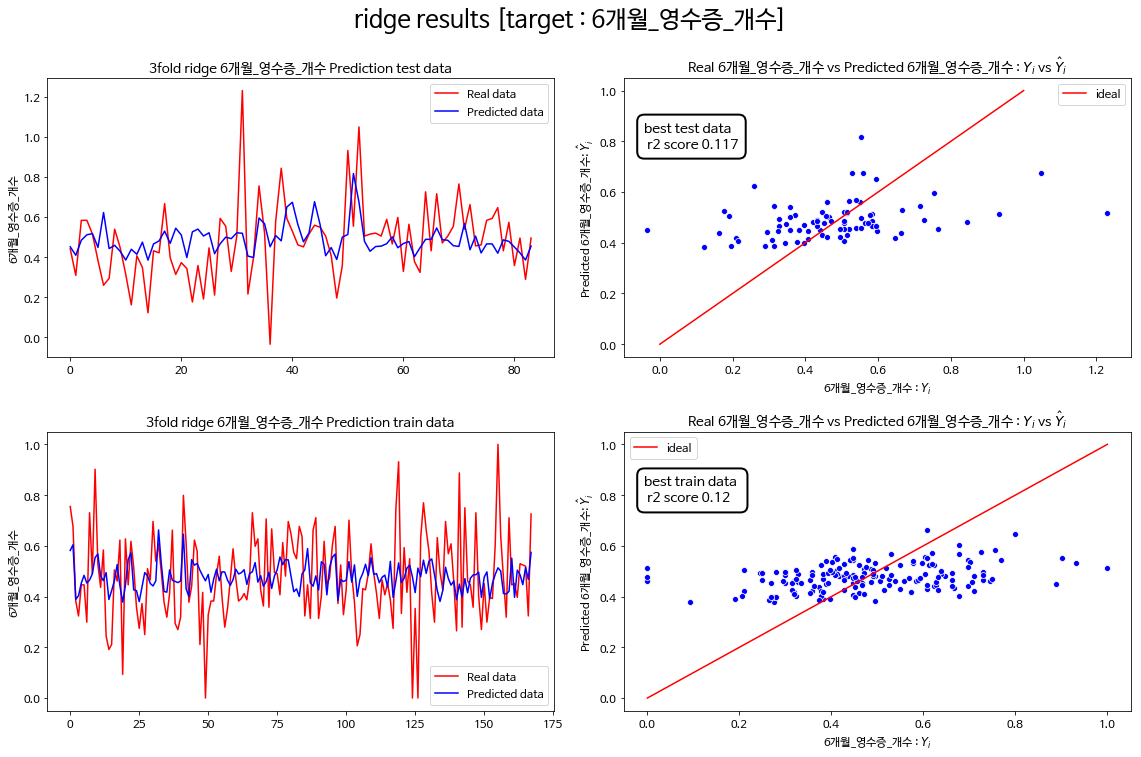

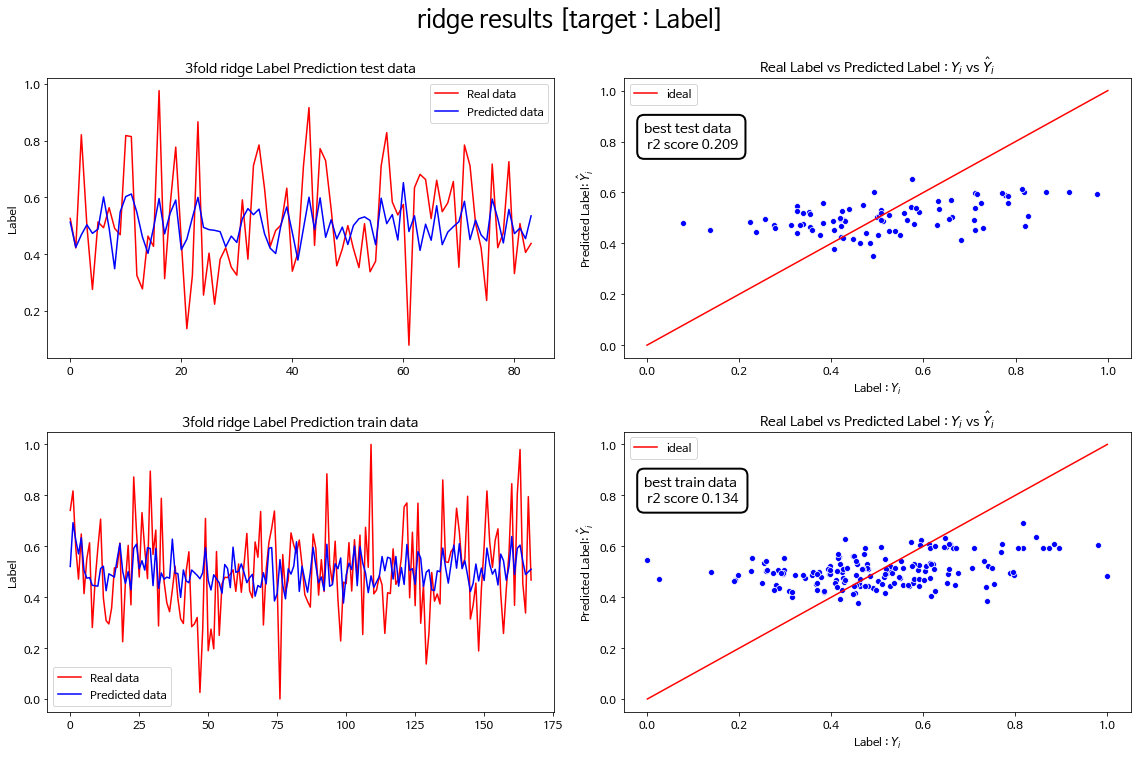

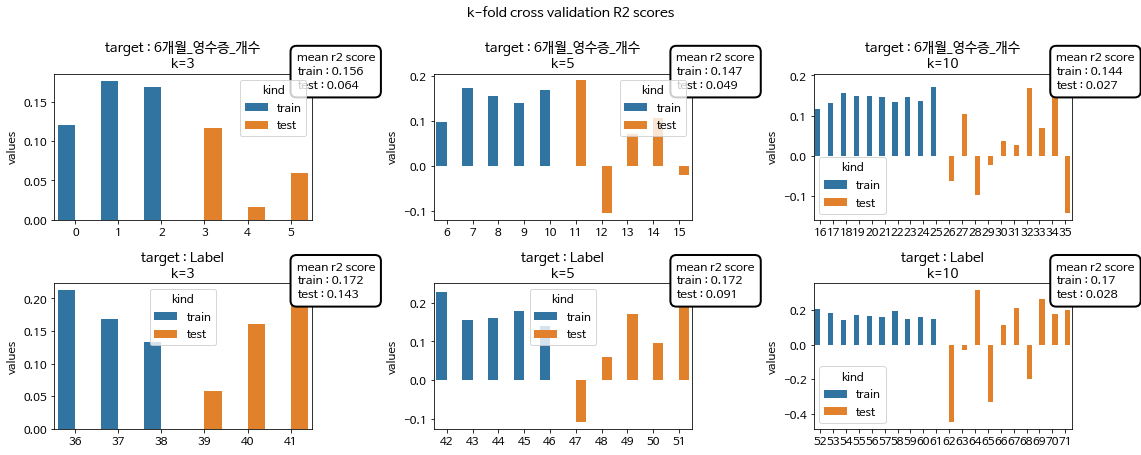

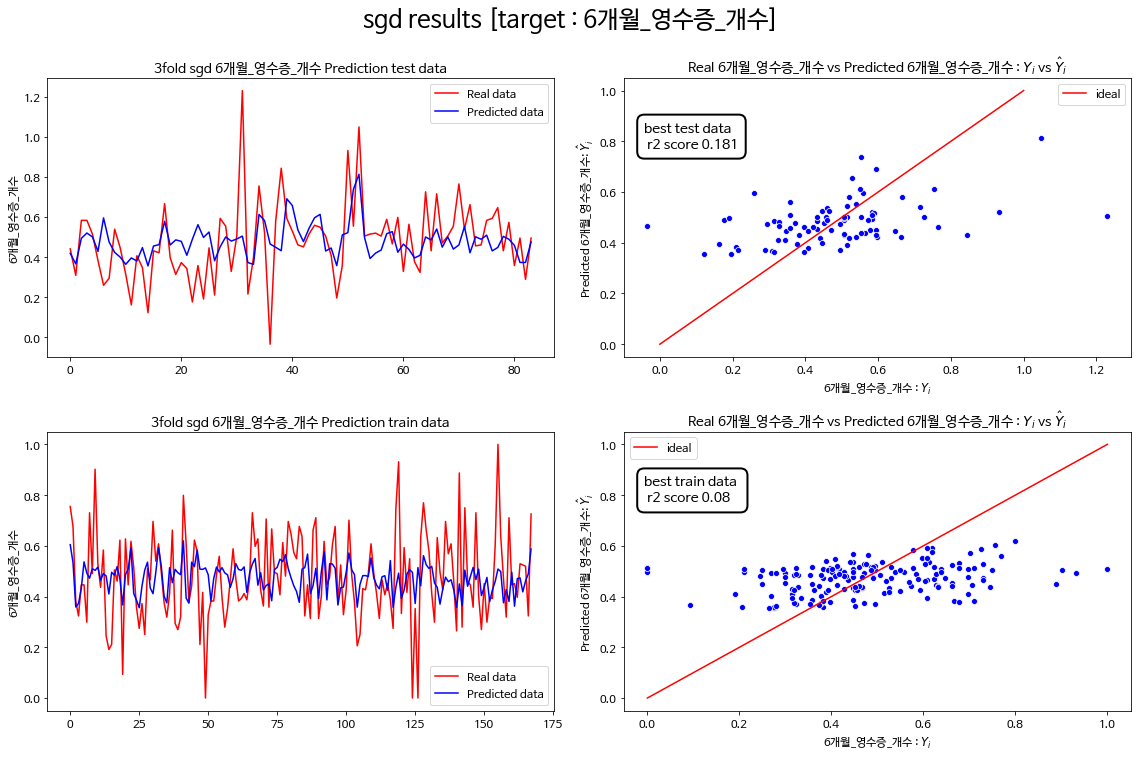

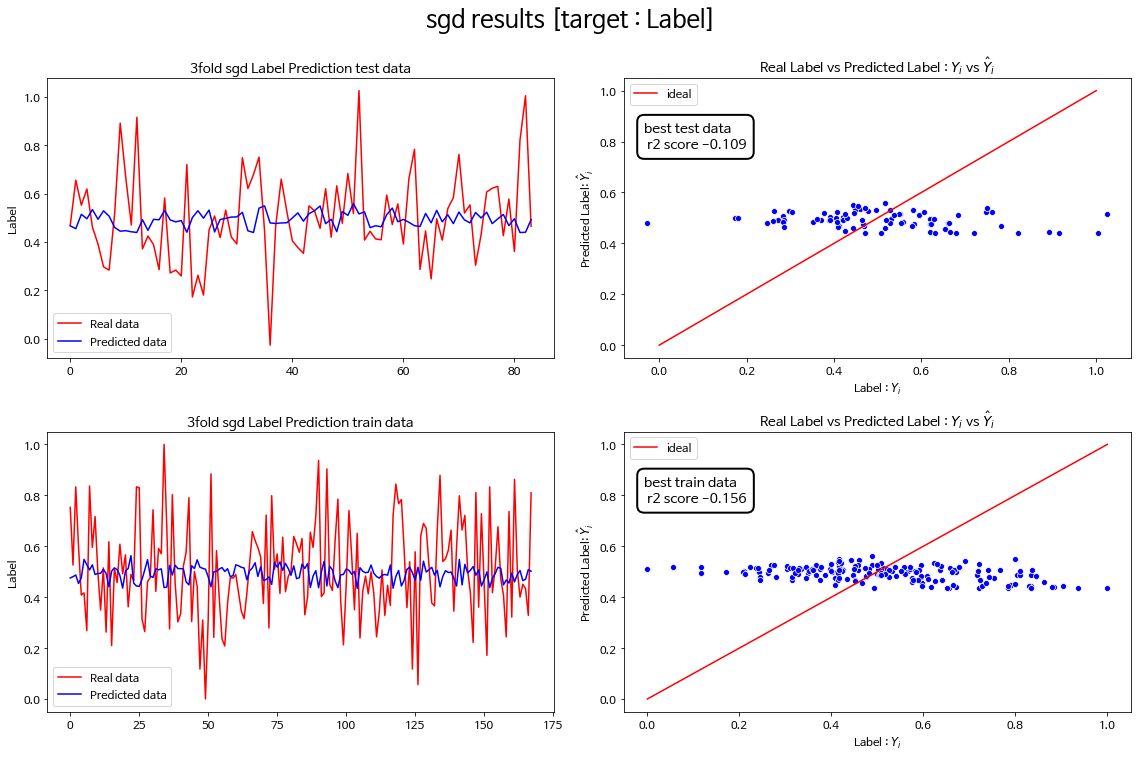

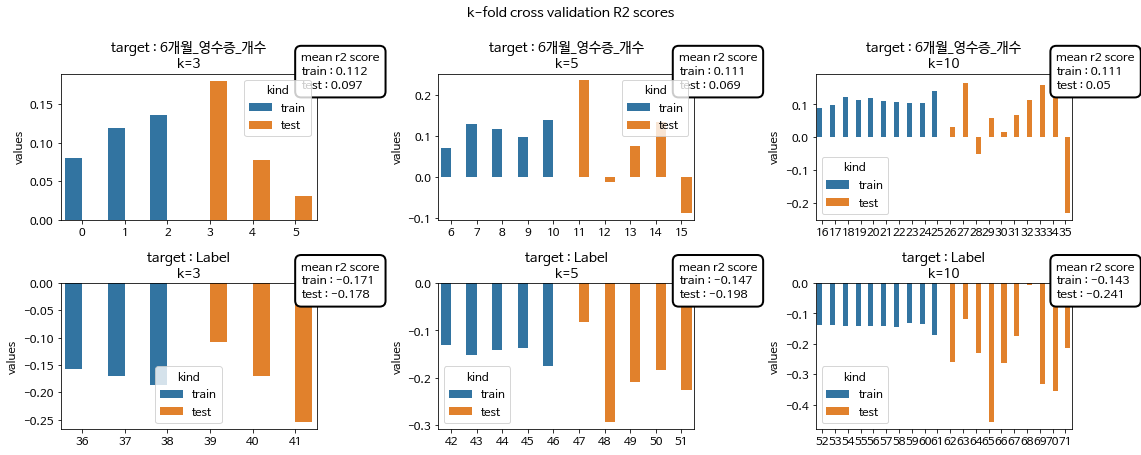

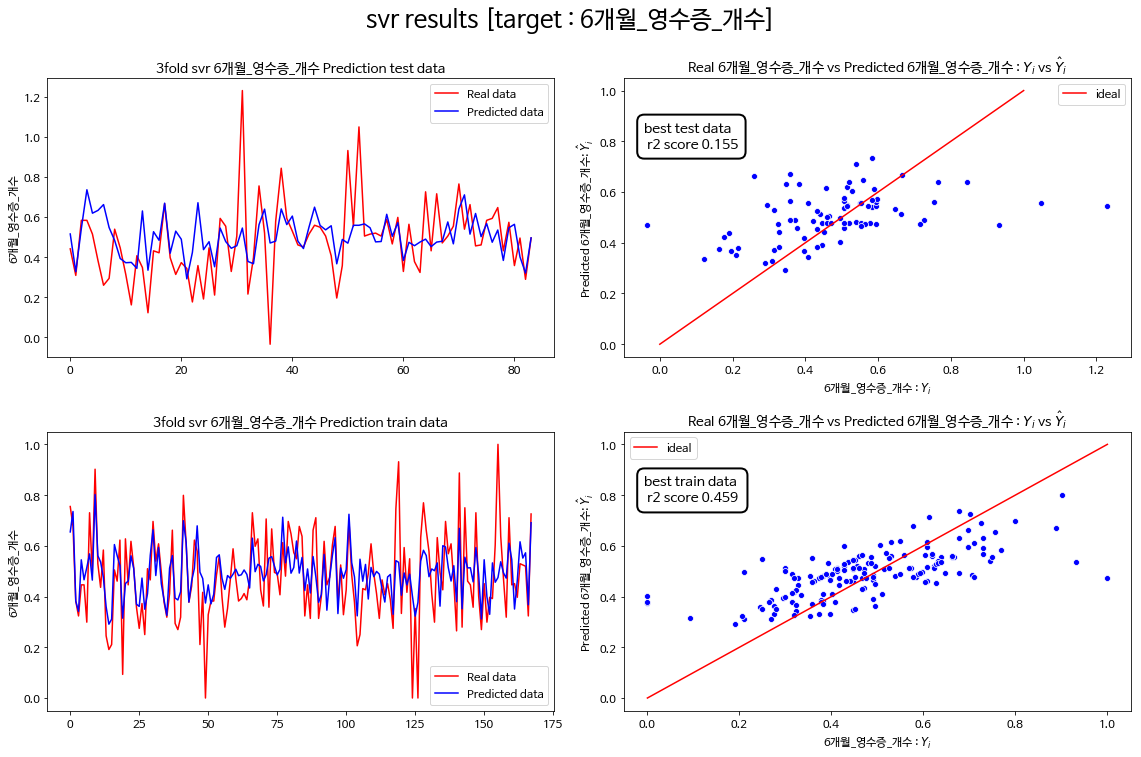

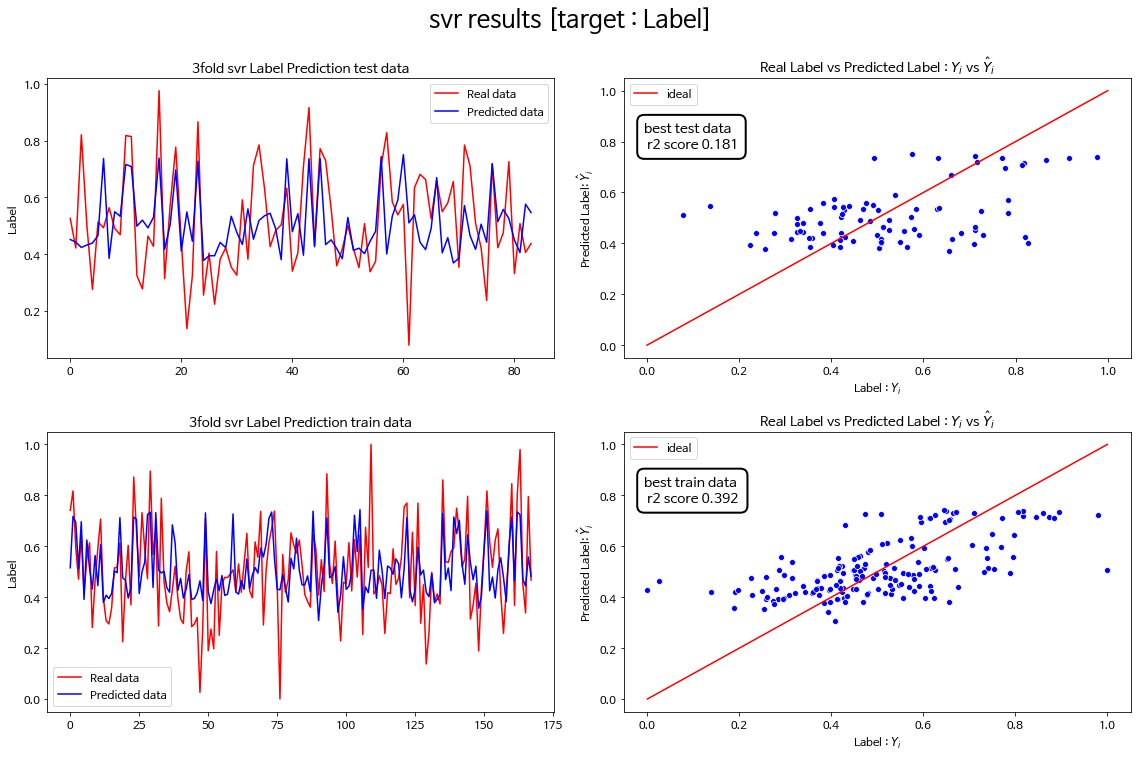

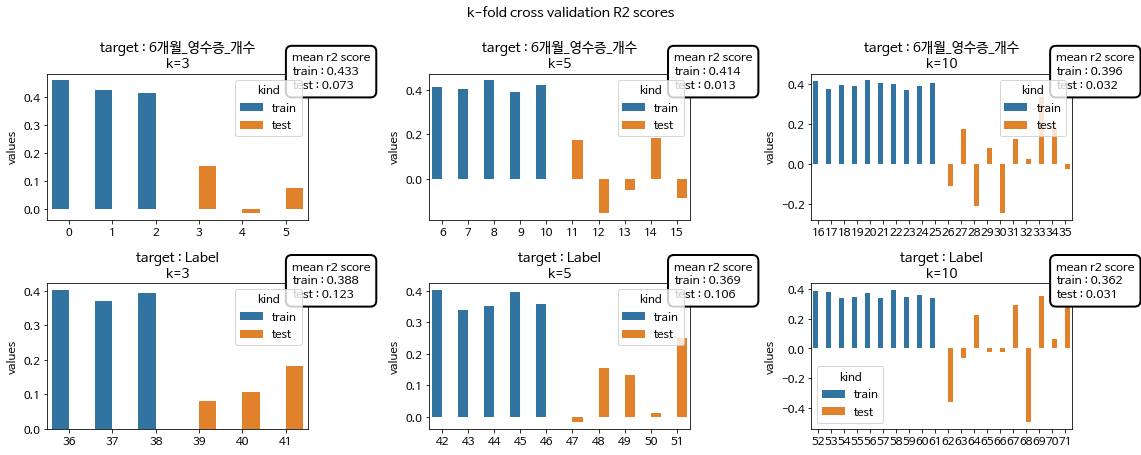

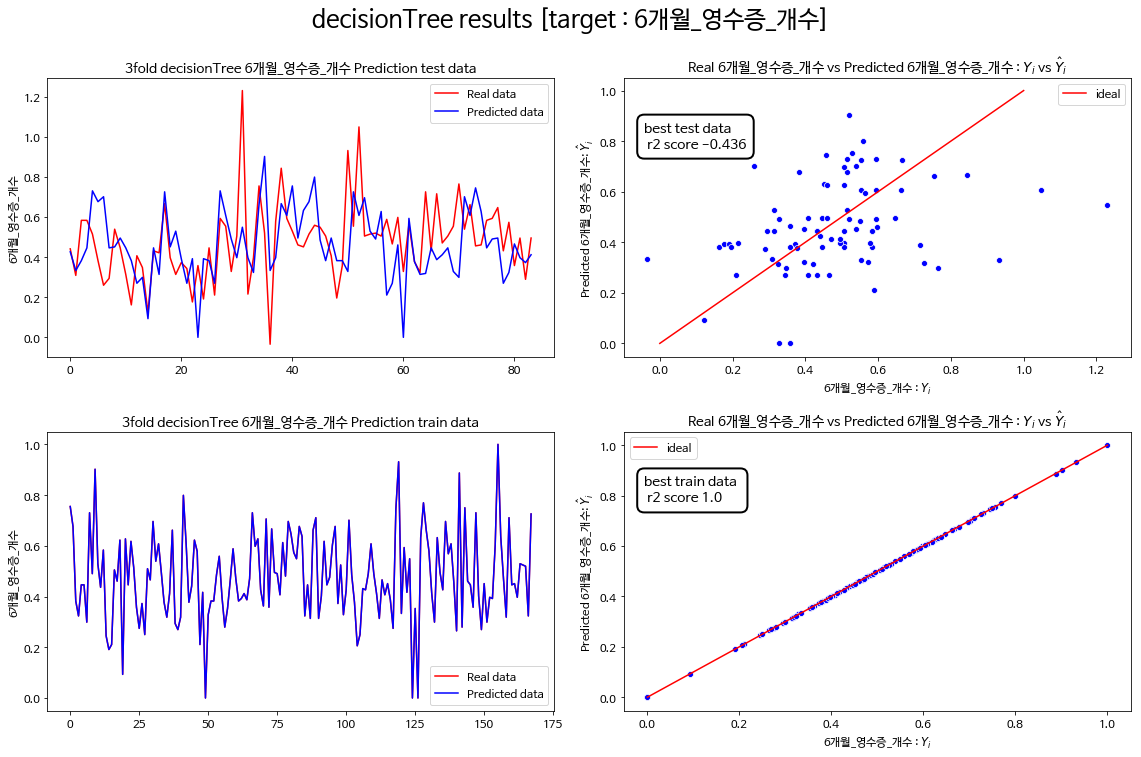

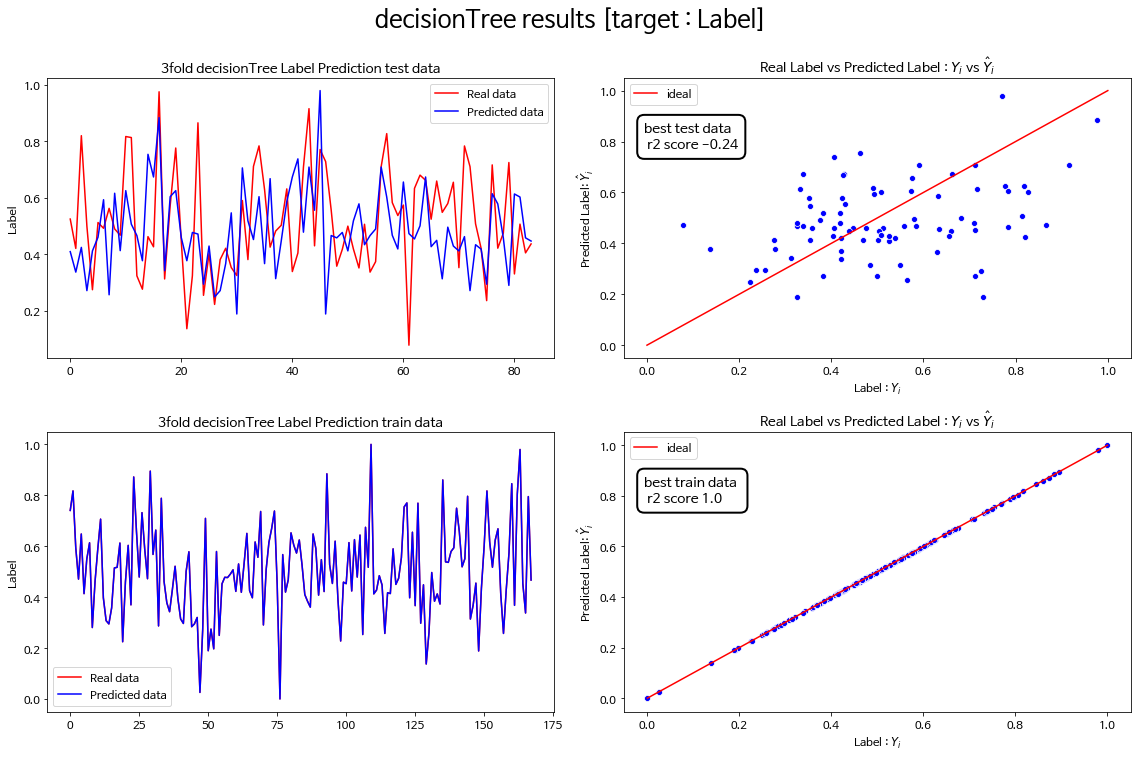

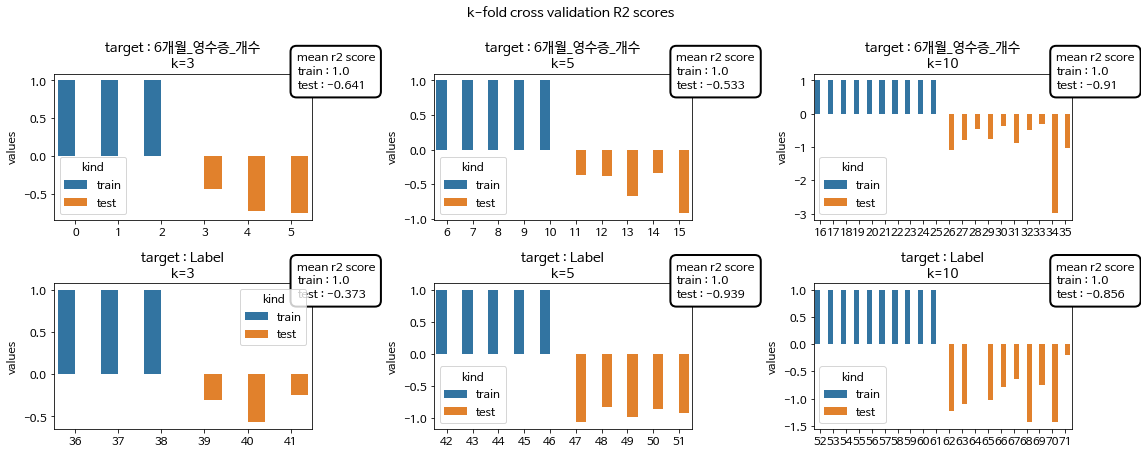

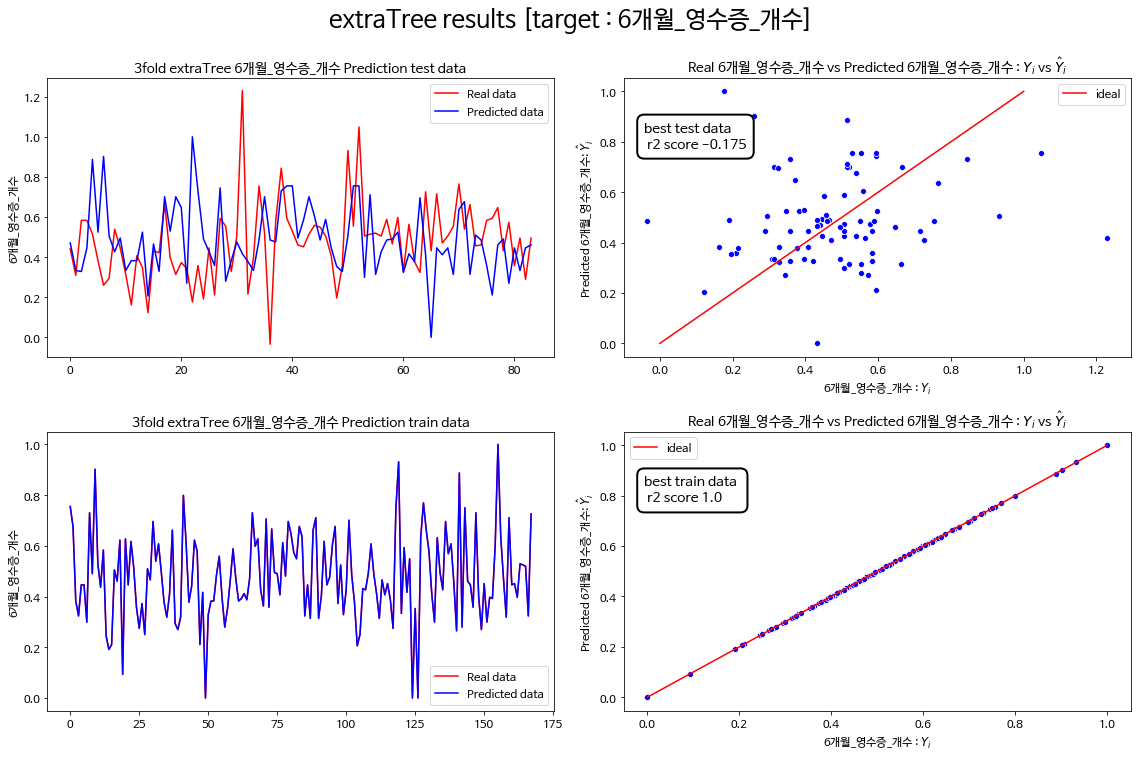

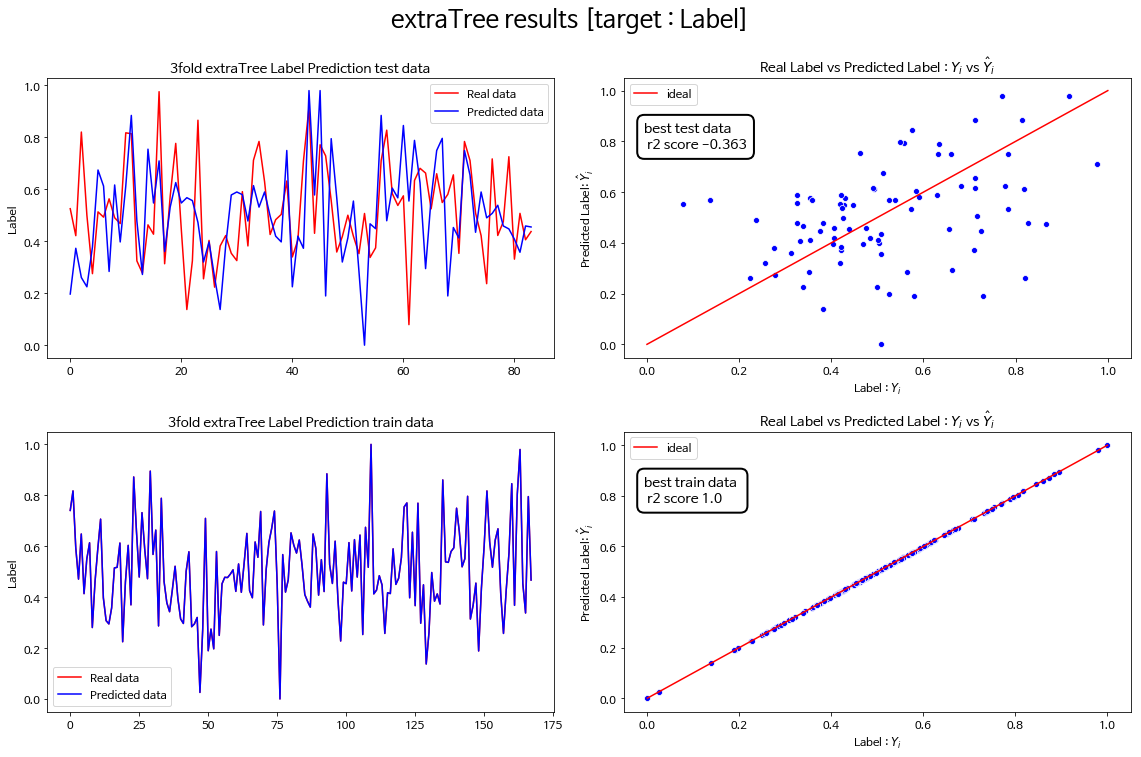

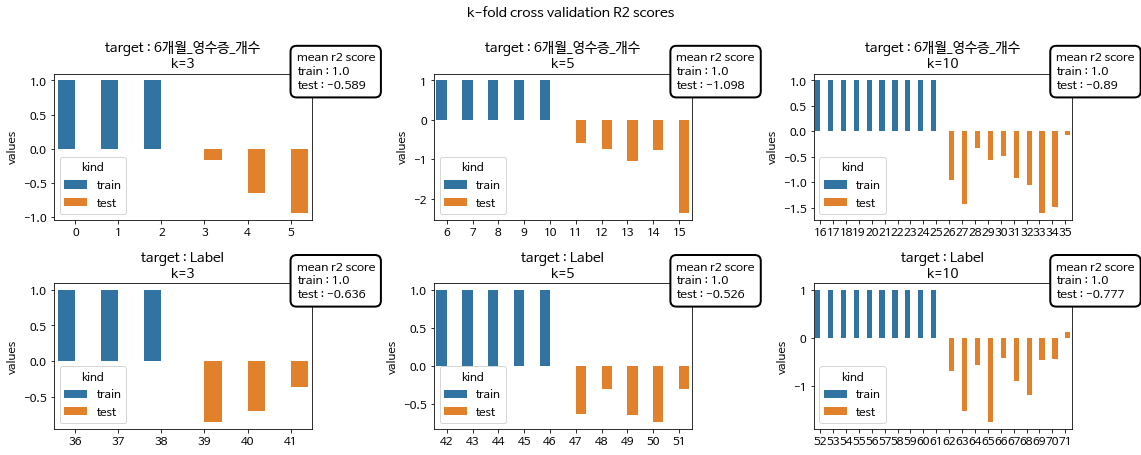

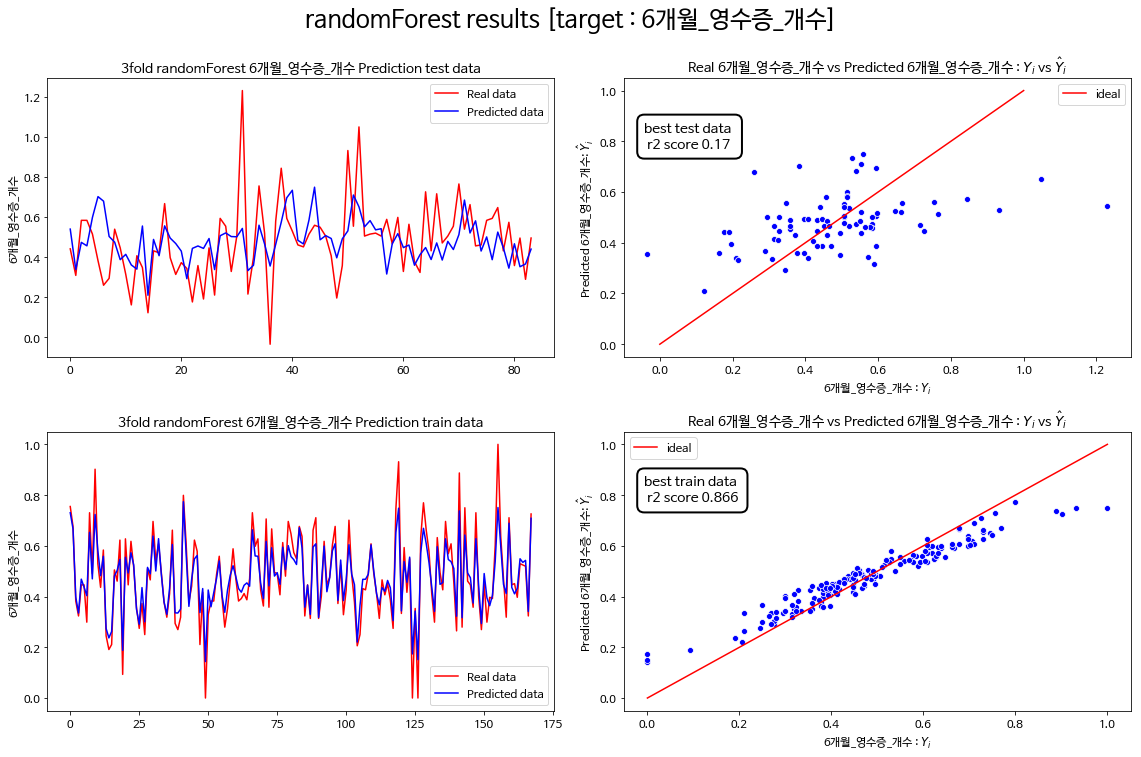

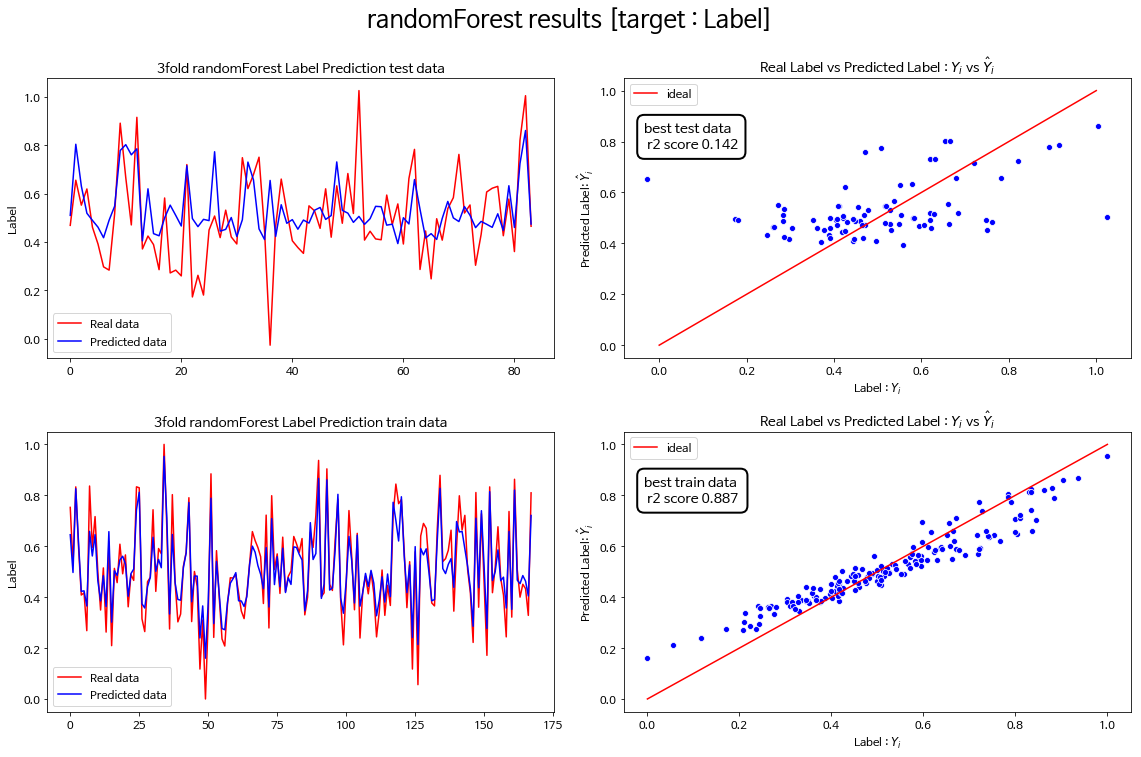

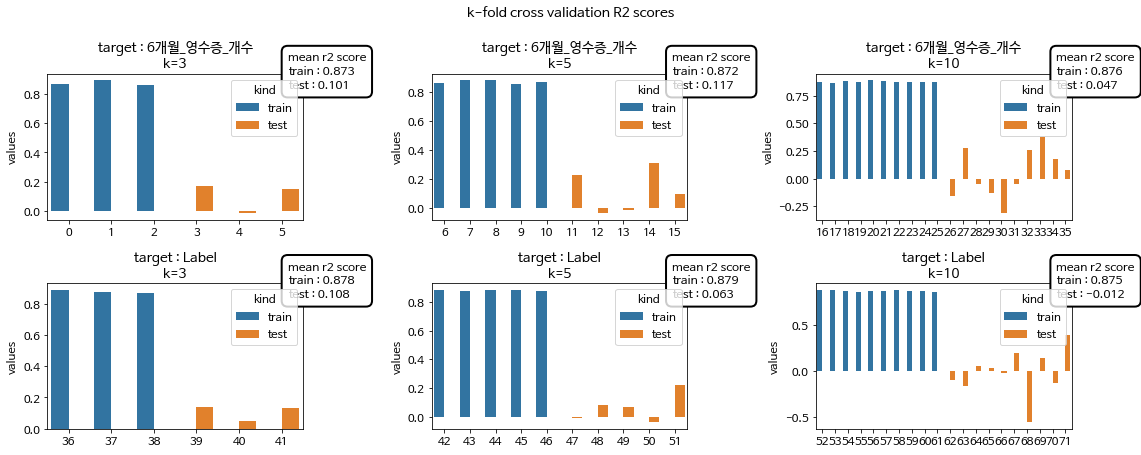

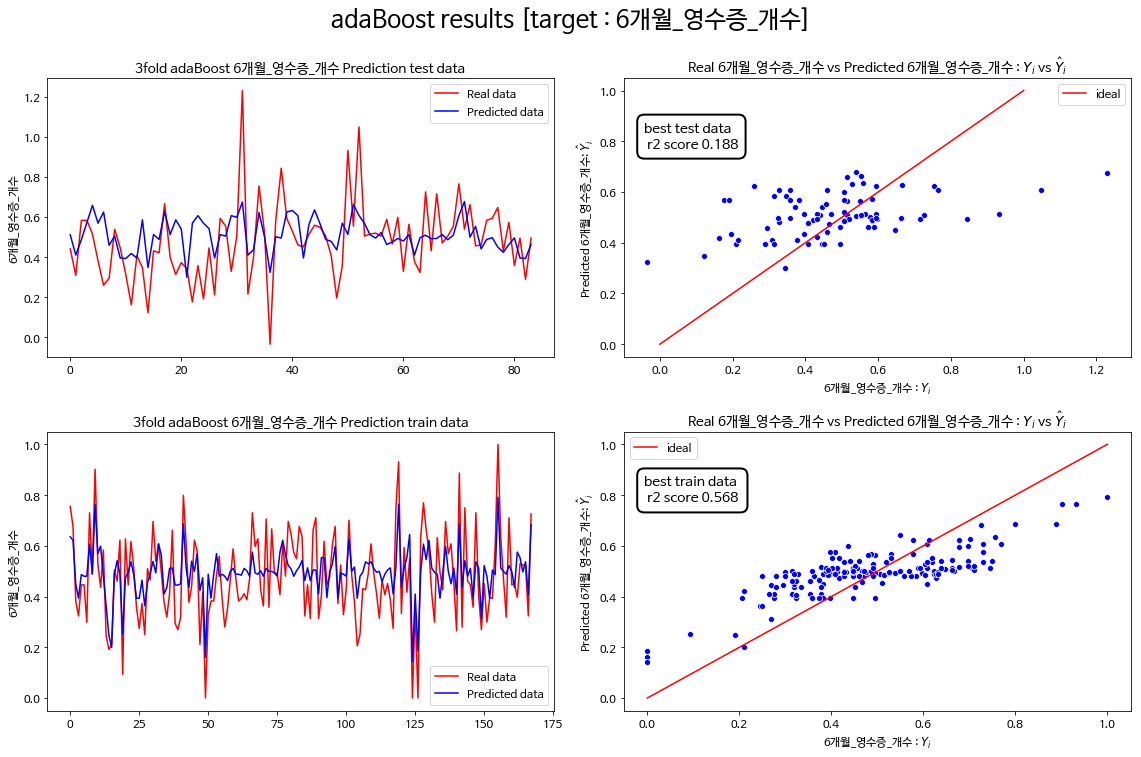

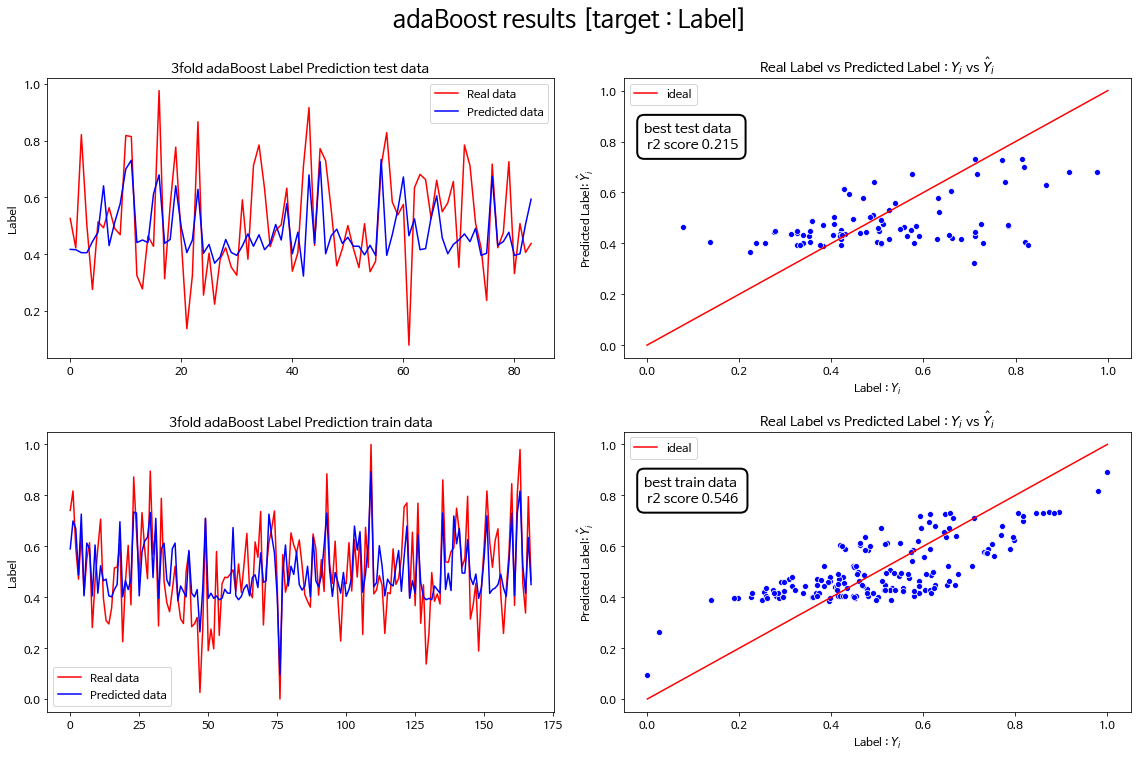

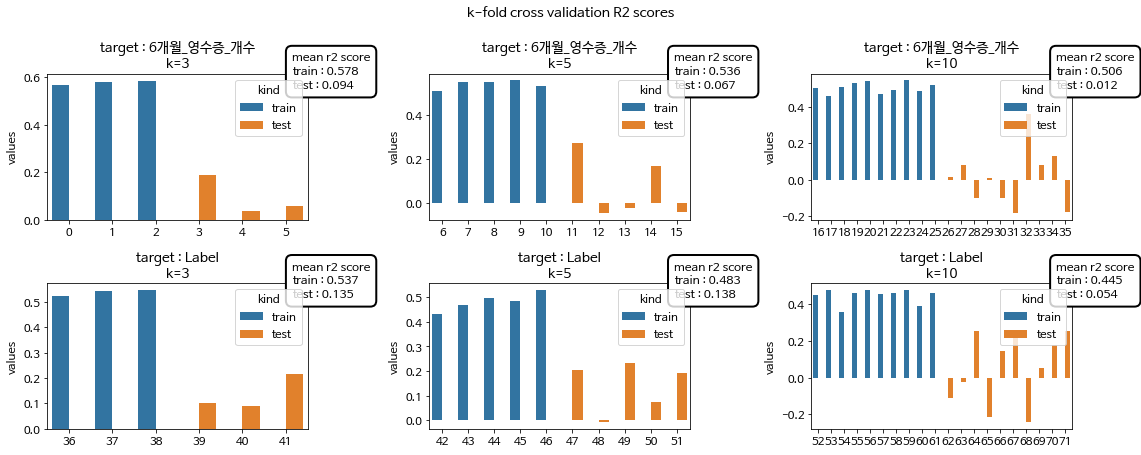

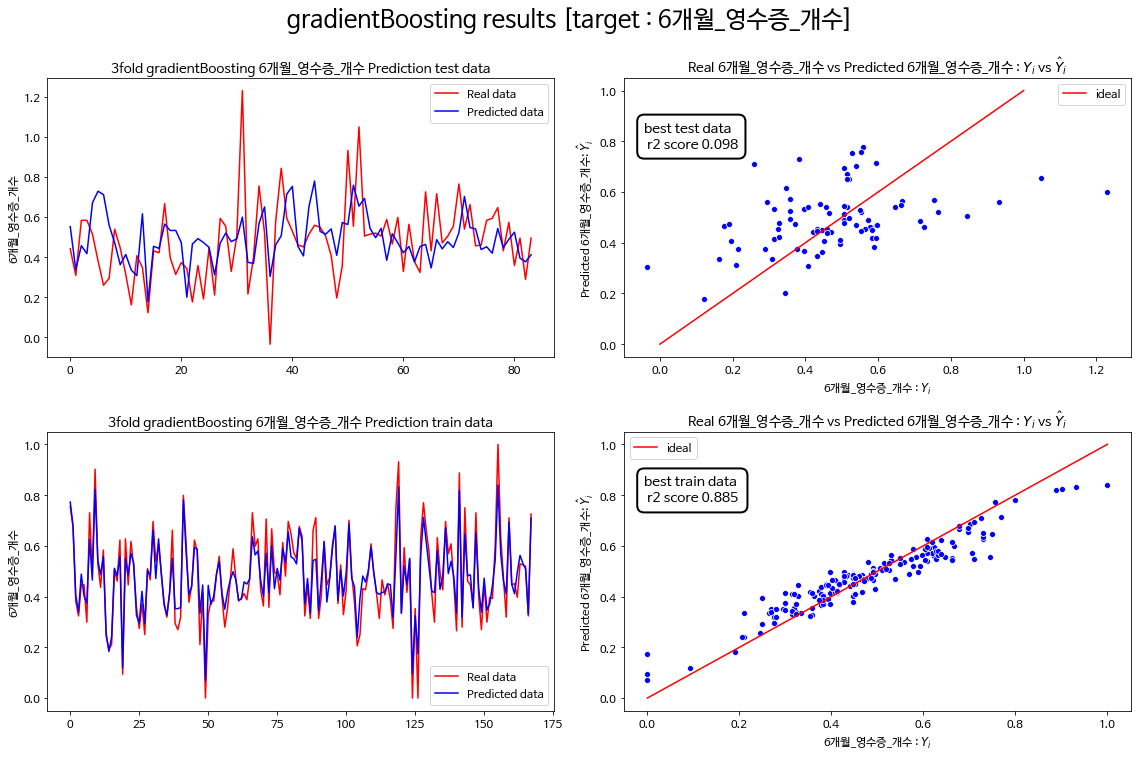

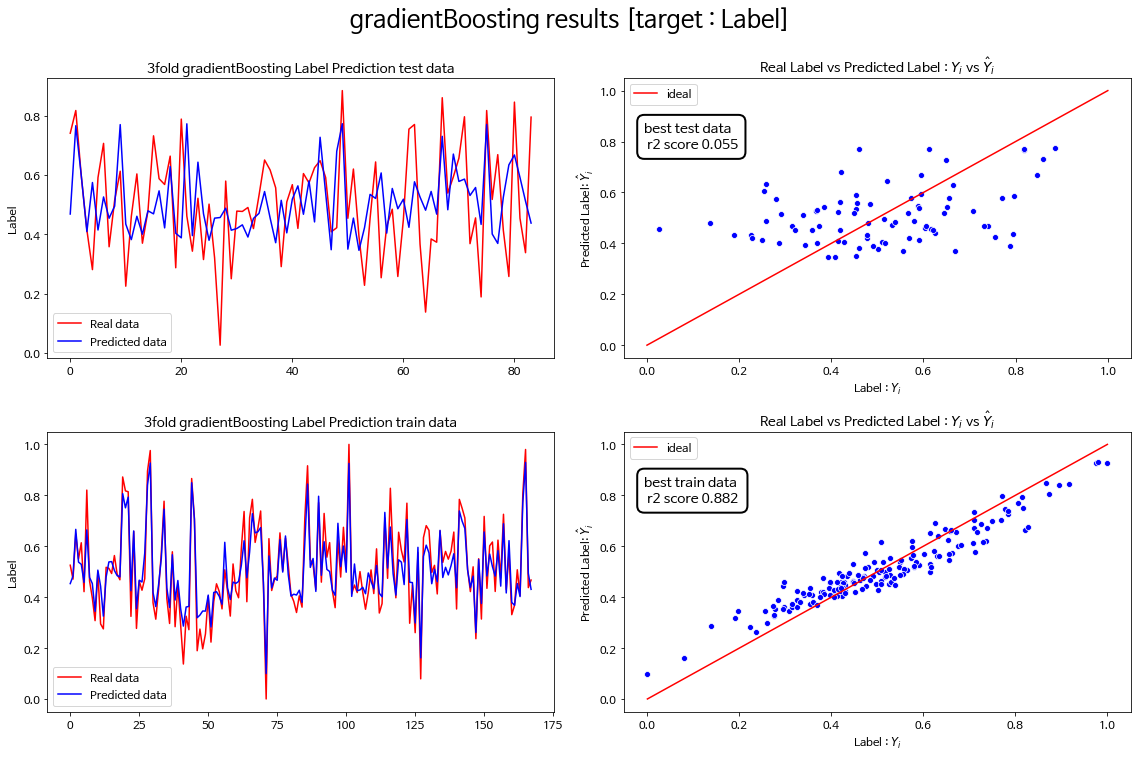

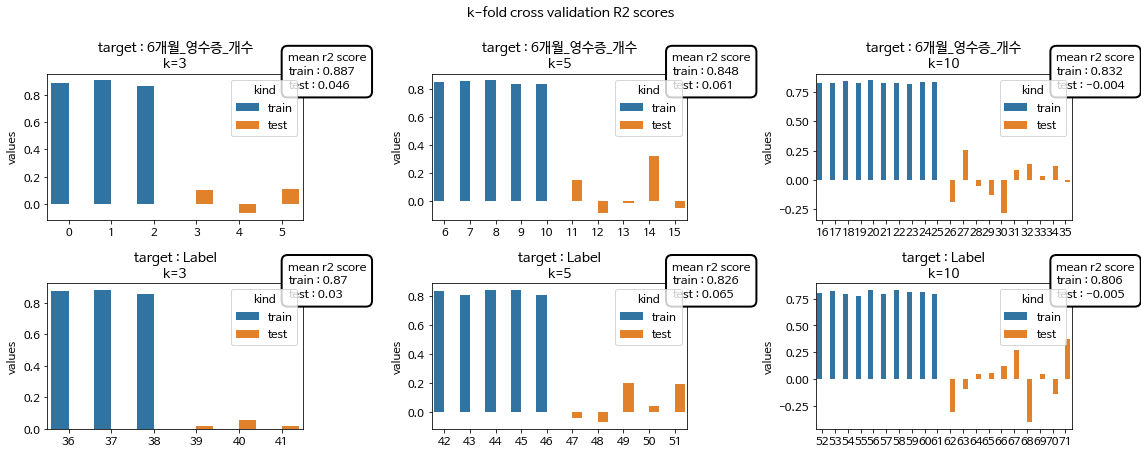

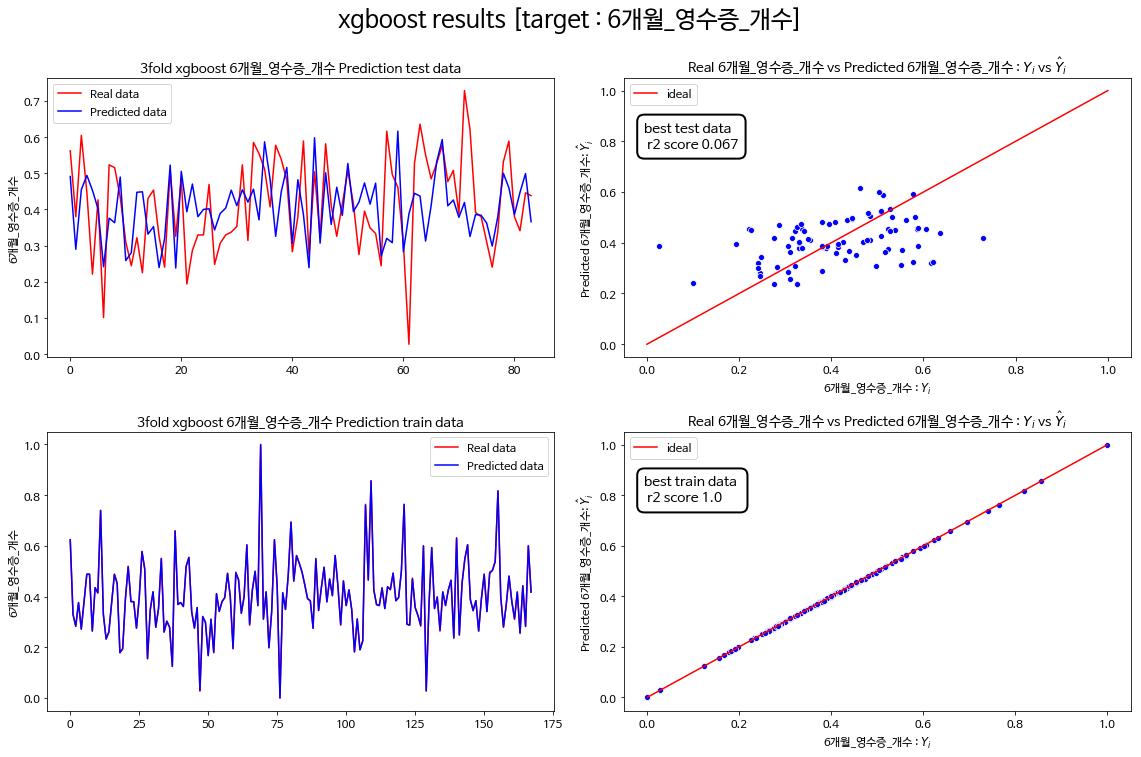

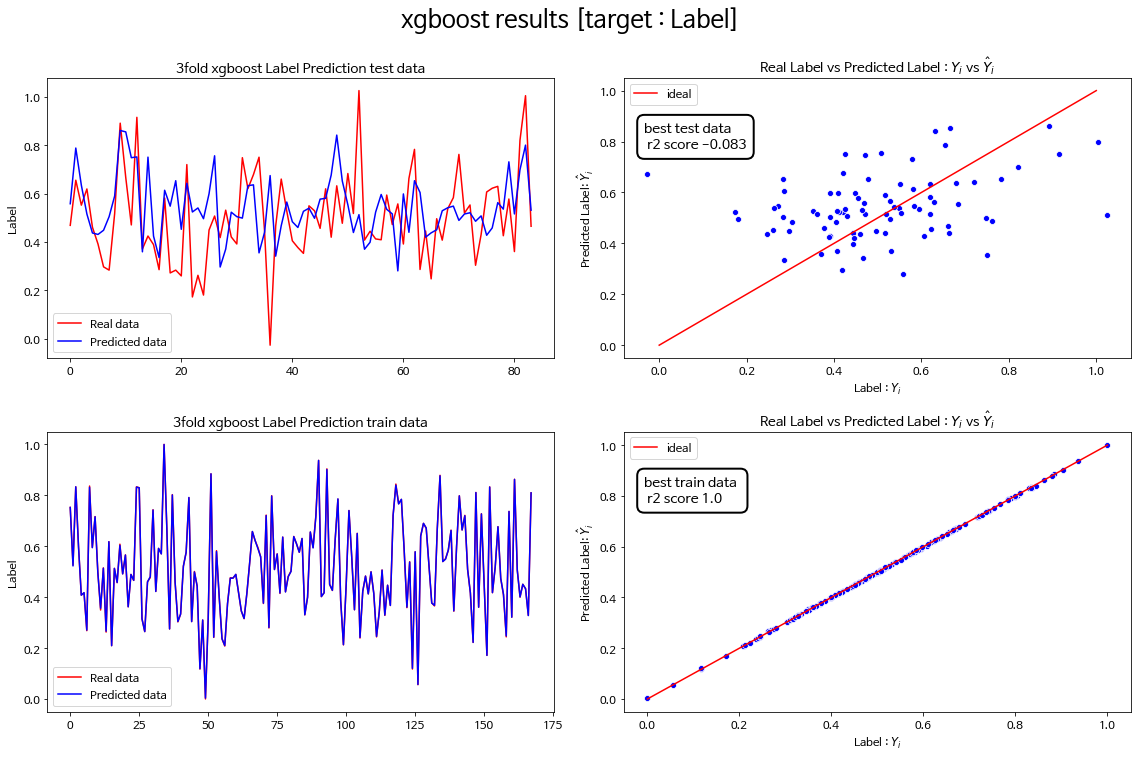

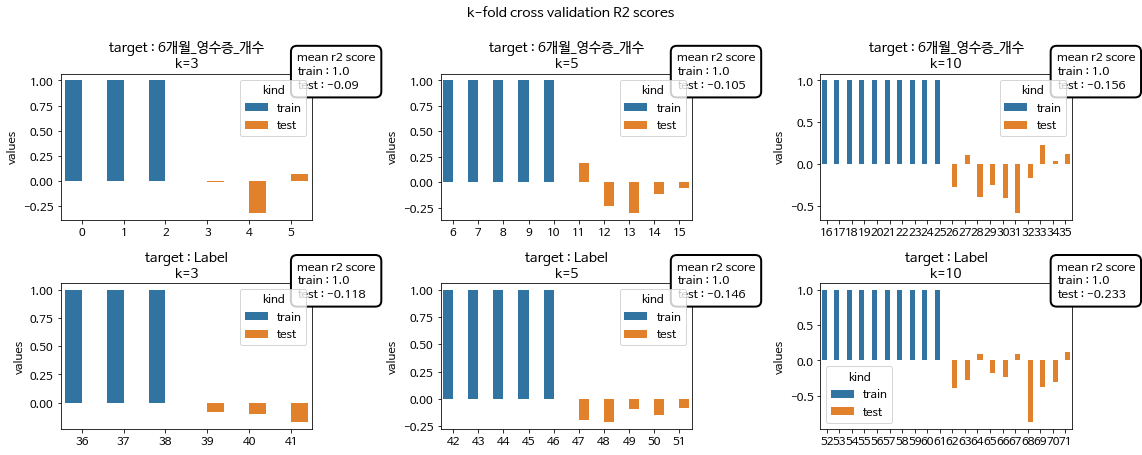

In [467]:
kfold_model['total_select'] = {}
kfold_results['total_select'] = {}
for model_name, model in models.items():
    kfold_model['total_select'][model_name], kfold_results['total_select'][model_name] = supervised_modeling(starbucksDT, model, model_name, feature_names_dict, target_lables)

## 관광 데이터

In [418]:
kfold_model['trip'] = {}
kfold_results['trip'] = {}

In [419]:
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
forest_model = RandomForestRegressor()

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label

3 is best for 6개월_영수증_개수

3 is best for Label



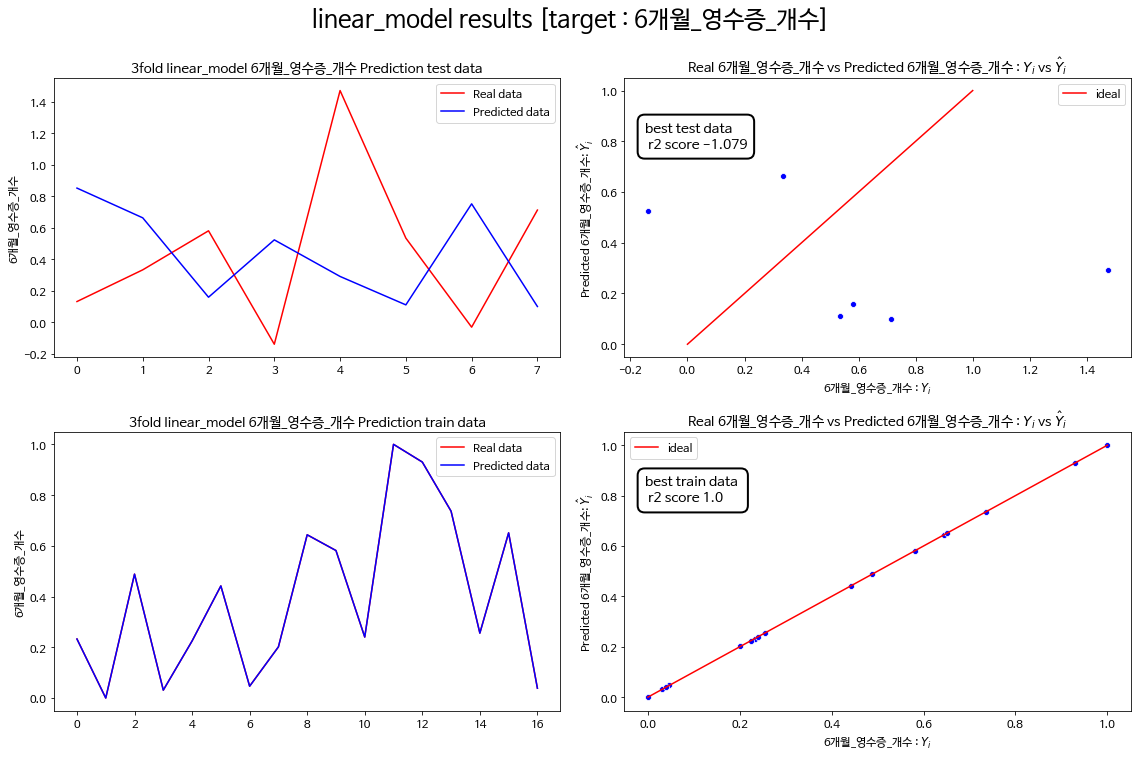

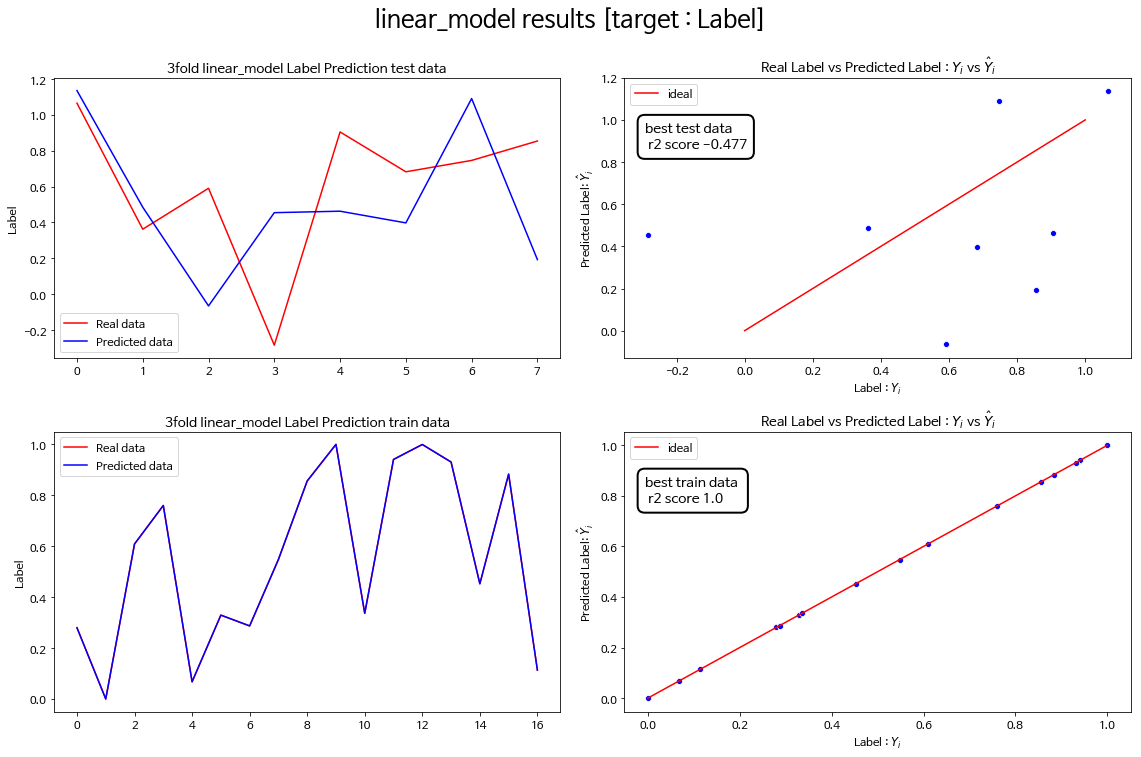

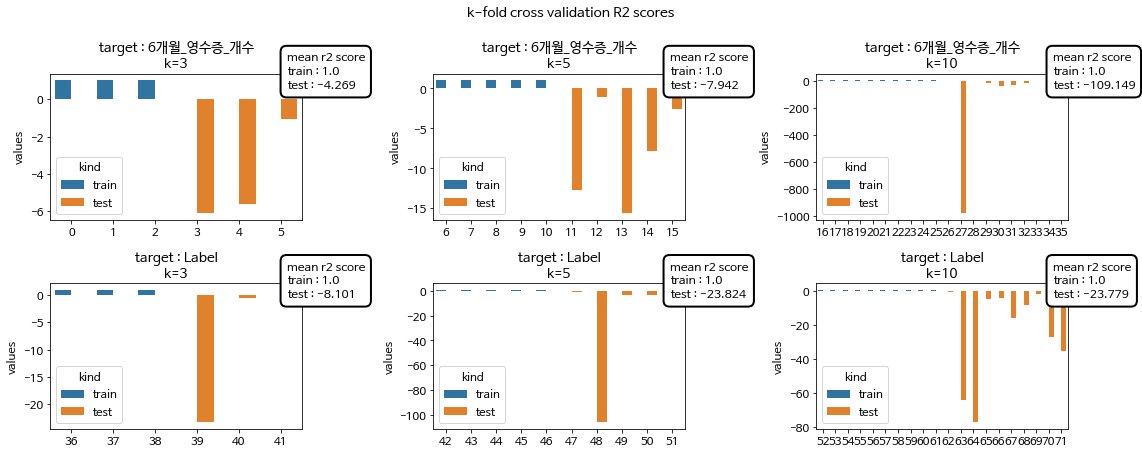

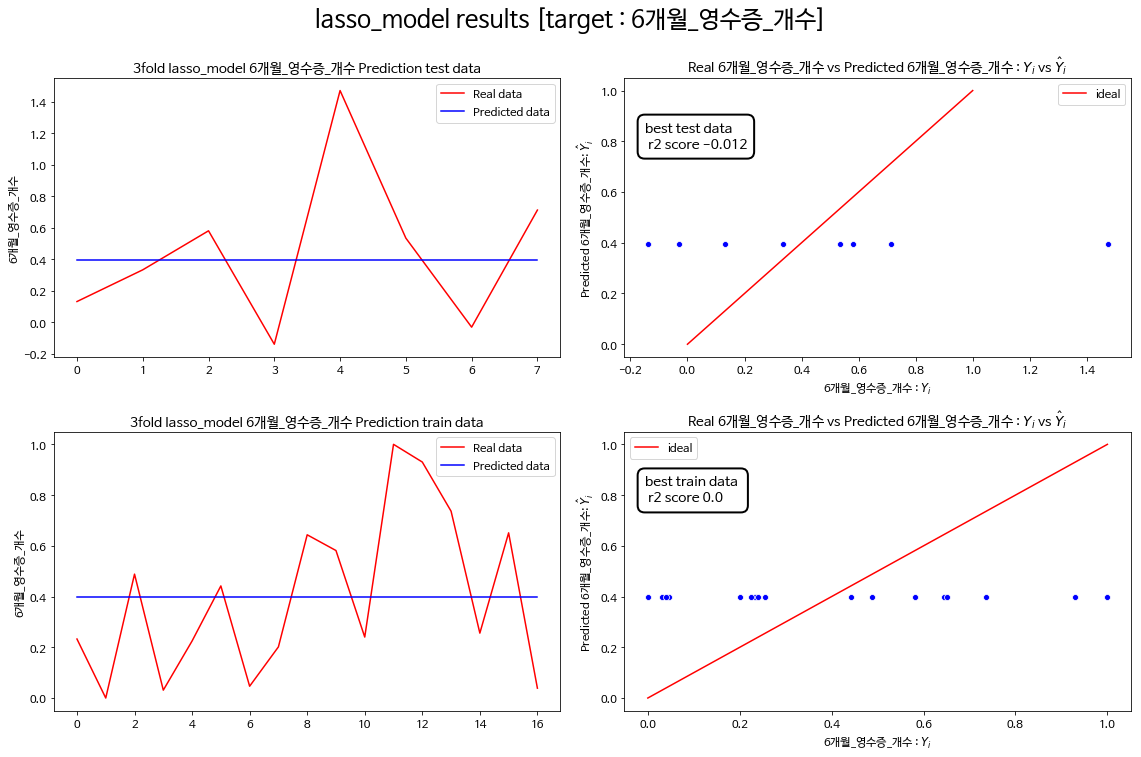

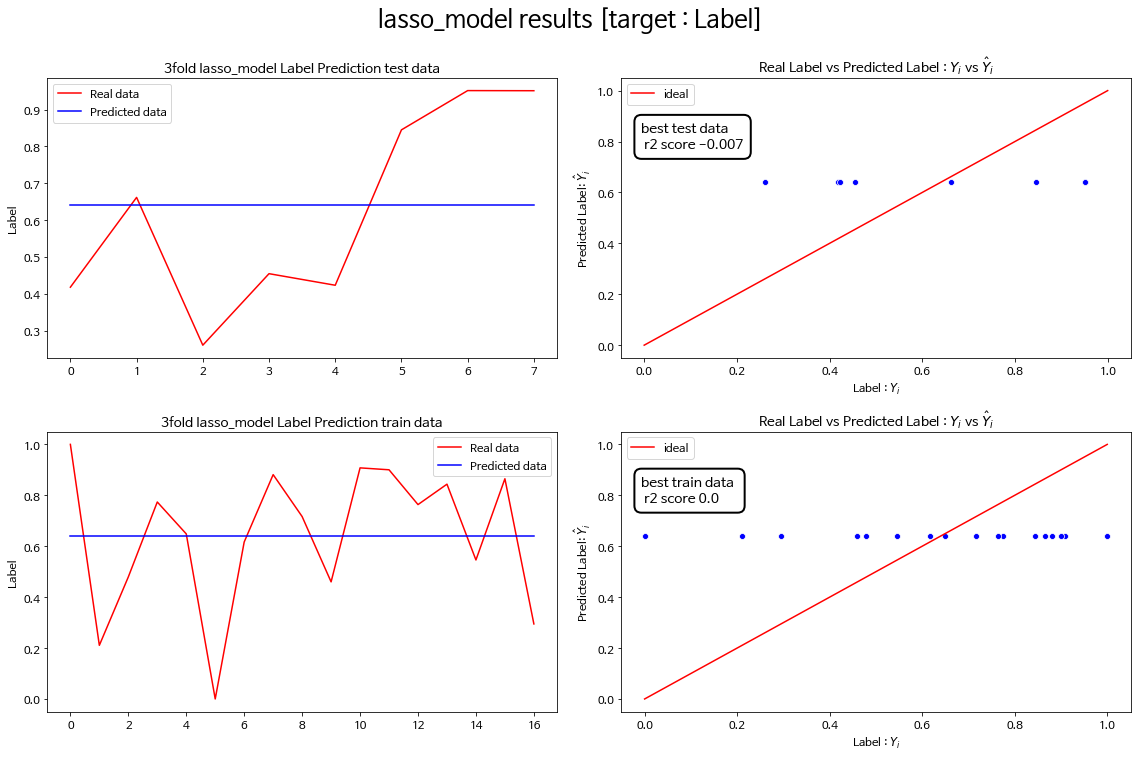

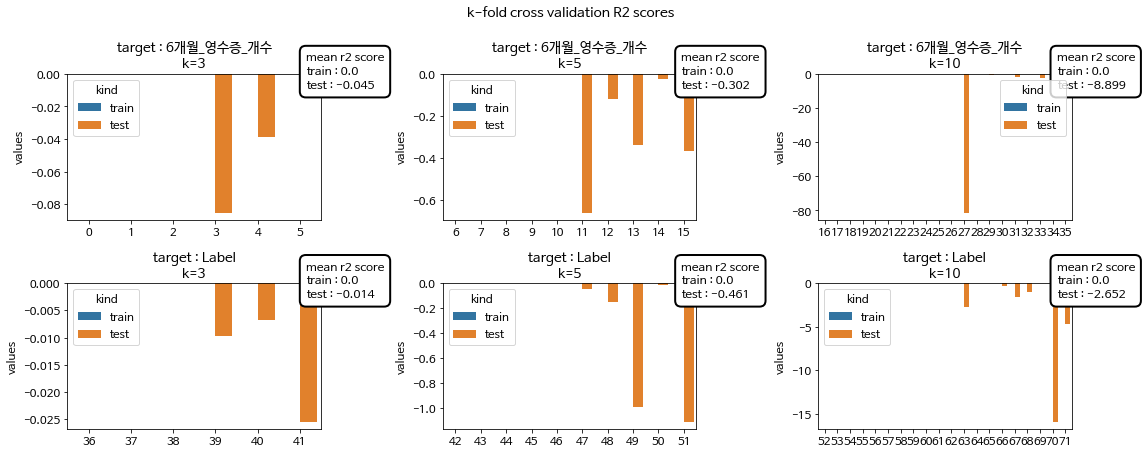

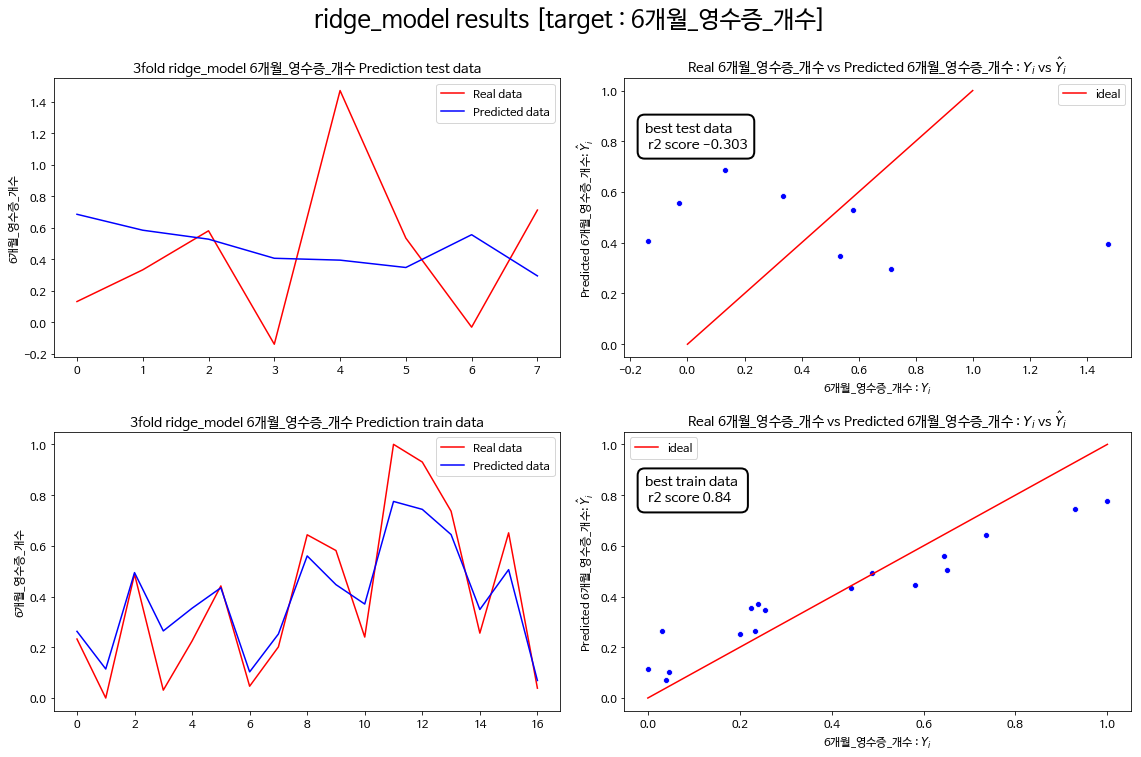

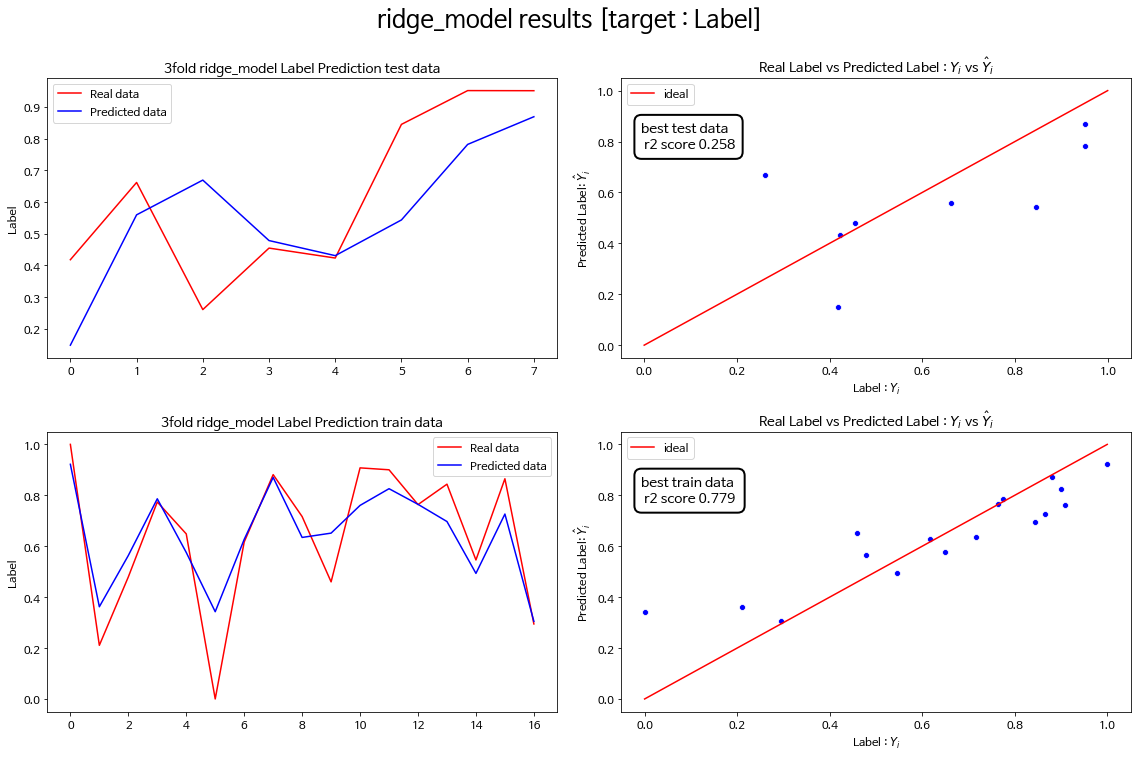

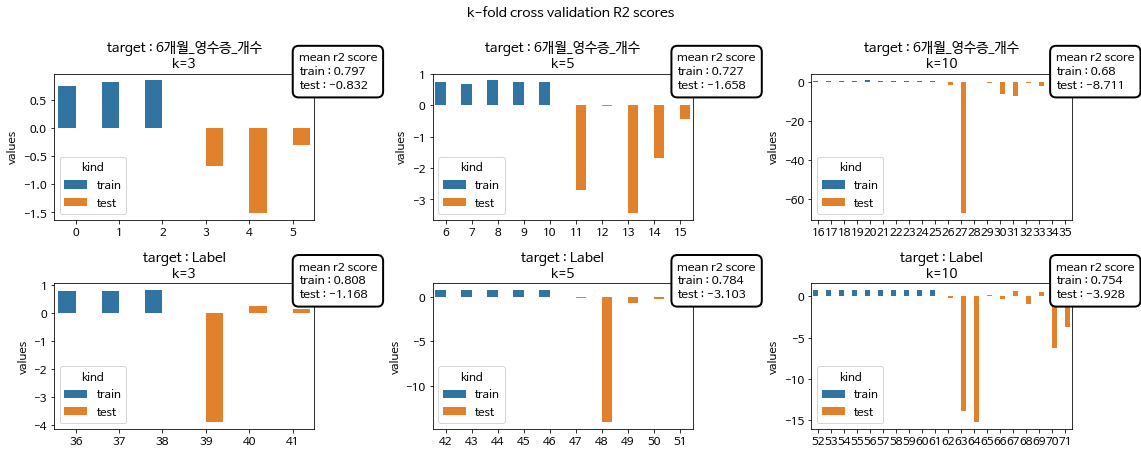

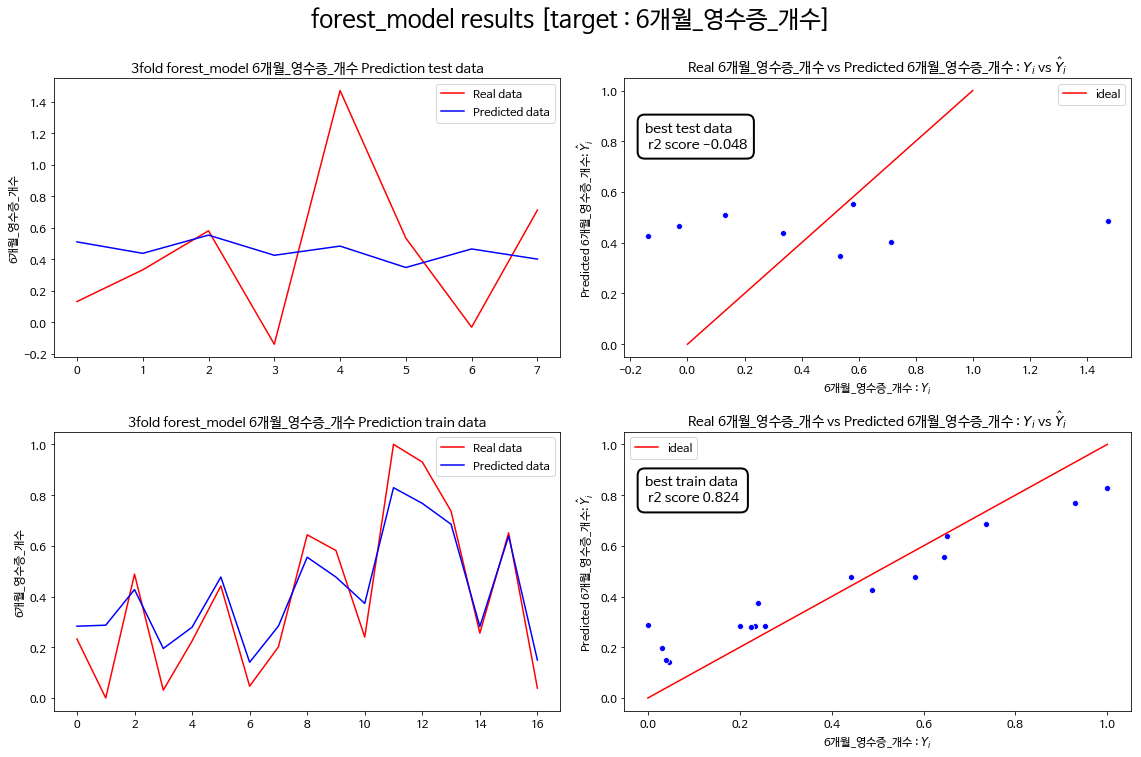

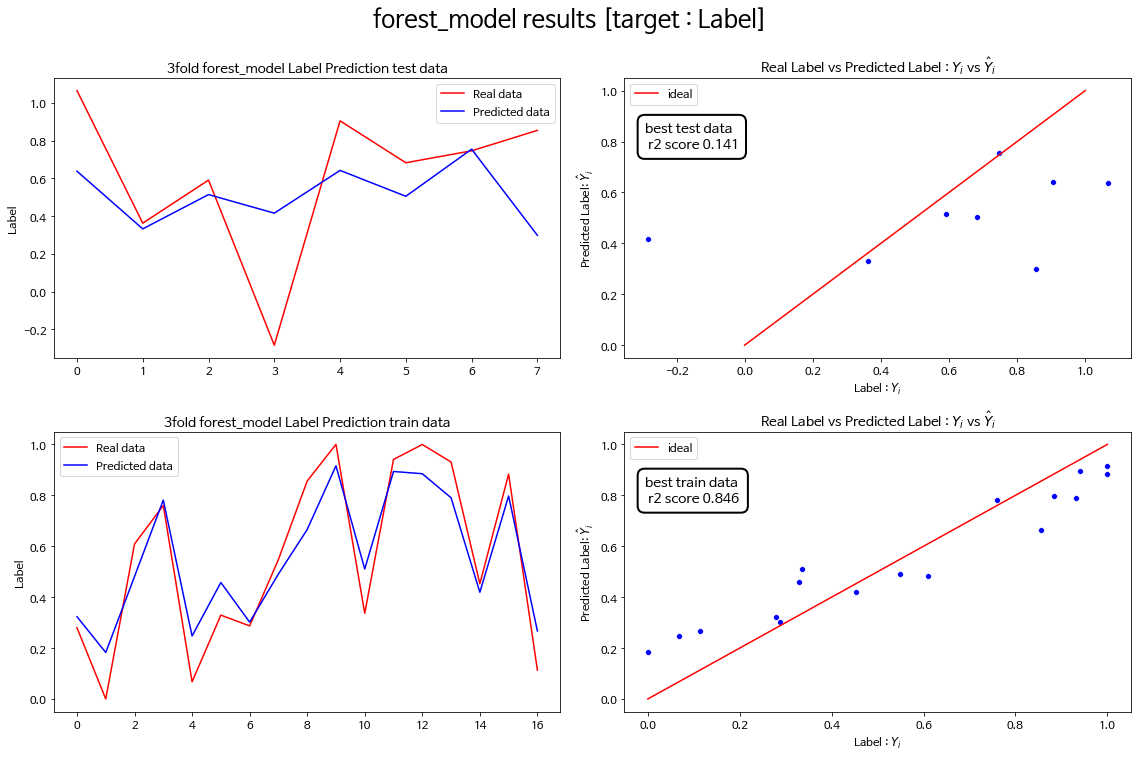

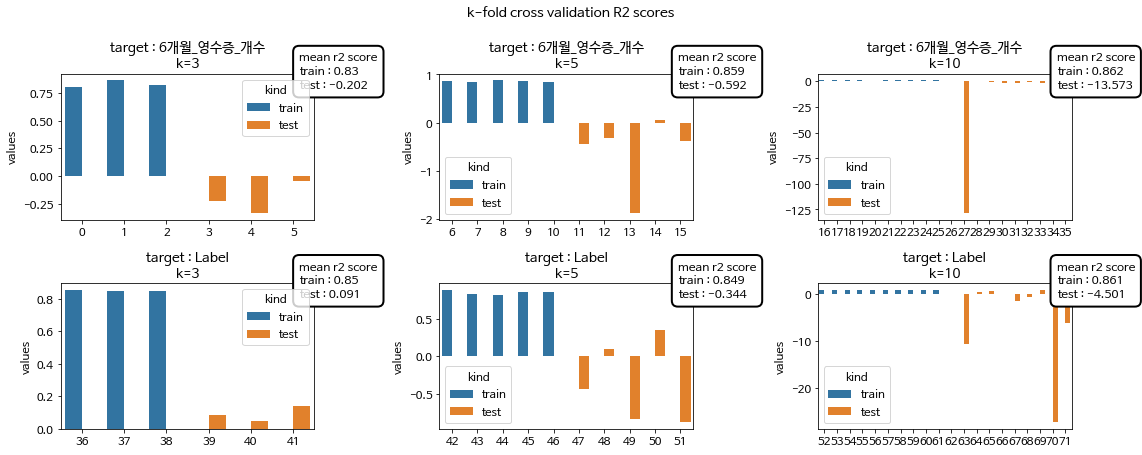

In [420]:
kfold_model['trip']['linear_model'], kfold_results['trip']['linear_model'] = supervised_modeling(stDT.trip, linear_model, 'linear_model', feature_names, target_lables)
kfold_model['trip']['lasso_model'], kfold_results['trip']['lasso_model'] = supervised_modeling(stDT.trip, lasso_model, 'lasso_model', feature_names, target_lables)
kfold_model['trip']['ridge_model'], kfold_results['trip']['ridge_model'] = supervised_modeling(stDT.trip, ridge_model, 'ridge_model', feature_names, target_lables)
kfold_model['trip']['forest_model'], kfold_results['trip']['forest_model'] = supervised_modeling(stDT.trip, forest_model, 'forest_model', feature_names, target_lables)